
<center>
<img src="https://drive.google.com/uc?id=1GkjZ9W02VQp4w4a4wA70NwRxDcwJJjWd" width="250" height="250" allow="autoplay"></img>


# <center> Classification of Musical Instruments<center/>
$ 
\fbox{
$ \scriptsize
Nihar\  Gupte \\
\scriptsize
Department\ of\ Electrical\ Engineering\\
\scriptsize
IIT\ Bombay \\
\scriptsize
213070002@iitb.ac.in
$
} \ \ \ \ \  \ \ \ \ \  \ \ \ \ \  \ \ \ \ \  \ \ \ \ \  \ \ \ \ \  \ \ \ \ \  \ \ \ \ \  \ \ \ \ \  \ \ \ \ \ 
\fbox{   
$\scriptsize
Harsh\ Diwakar\\
\scriptsize
Department\ of\ Electrical\ Engineering\\
\scriptsize
IIT\ Bombay \\
\scriptsize
213070018@iitb.ac.in
$
} 
$
<center/>


In this notebook, we have implemented classification of musical instruments using the IRMAS Dataset.

The dataset link is provided here :    [IRMAS Dataset](https://www.upf.edu/web/mtg/irmas)


## Outline

- [1. Introduction](#1)
  - [1.1 Importing libraries](#1.1)
  - [1.2 Linking Google drive](#1.2)
  - [1.3 Dataset](#1.3)

- [2. Method 1](#2)
  - [2.1 Feature extraction](#2.1)
  - [2.2 K means clustering](#2.2)
  - [2.3 Nearest Neigbours](#2.3)
  - [2.4 Testing the model](#2.4)
  - [2.5 Confusion Matrix observation](#2.5)
  - [2.6 Accuracy vs 'K' plot](#2.6)
  - [2.7 Model Observations](#2.6)

- [3. Method 2](#3)

  - [3.1 Feature extraction and importance](#3.1)
  - [3.2 K means clustering](#3.2)
  - [3.3 Nearest Neigbours](#3.3)
  - [3.4 Testing the model](#3.4)
  - [3.5 Model Observations](#3.6)
- [4. Method 3 (Neural Network)](#4)
  - [Input and Output preparation](#4.1)
  - [One Hot Encoding](#4.2)
  - [Model Architecture](#4.3)
  - [Model evaluation](#4.4)
- [5. Techniques learnt during the project](#5)
- [6. Conclussion and Future work](#6)
- [References](#7)


<a name="1"></a>
# 1 Introduction

Today, huge amount of digital data is all around us. Musical instruments and their audio is one of them. The applications of Musical classification extend from Indexing Annotation and transcription of database Knowing various musical styles, playlist generation, Video scene analysis, etc. The dataset consists of 11 different classes. Our project uses K Means clustering for codebook preparation, nearest neighbours for classifying and finally a simple neural network to observe how modern approaches work when compared to classical techniques. 




The packages used for our project are :    

- numpy
- os
- glob
- tensorflow
- keras
- pandas
- librosa
- re 
- matplotlib.pyplot
- IPython.display
- sklearn
- pickle
- seaborn
- plotly.express
- plotly.graph_objects

<a name="1.1"></a>
## 1.1 Importing the libraries

In [ ]:
import numpy as np
import os
import glob
import tensorflow as tf
import pandas as pd 
import librosa 
import re
import matplotlib.pyplot as plt
import librosa.display
import IPython.display
import sklearn 
import pickle
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


<a name = "1.2"></a>
## 1.2 Linking Google drive

Linking the google drive to access the directories of shared drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name = "1.3"></a>
## 1.3 Dataset

Instrument recognition in musical audio signals (IRMAS) dataset contains 11 Classes.

- Cello (cel) 
- Clarinet (cla)
- Flute (flu)
- Acoustic guitar (gac)
- Electric guitar (gel)
- Organ (org)
- Piano (pia)
- Saxophone (sax)
- Trumpet (tru)
- Violin (vio),
- Human singing (voi)

Training: 6705 audio files, 16 bit stereo at 44.1 kHz
Testing: 2874 audio samples divided into three parts.


The Sampling rate for all the samples in IRMAS Dataset is 44100 kHz

In [ ]:
Fs = 44100

Reference Dictionary just to classify each class ordinally. This dictionary will essentially classify each class as a number between 0 to 10. The labels are mentioned in the dictionary below.

In [ ]:
reference_dict = {
    'gac' : 0, 'tru':1, 'flu':2, 'pia':3, 'cla':4, 'voi':5, 'org':6, 'vio':7, 'gel':8, 'sax':9, 'cel':10
}

<a name="1.4"></a>
## 1.4 Methods 

In this project, we have used three methods.

\

- Method 1 : Windowing input signal into frame and treating each frame as a single training instance. Each frame is split into 24 features.

\
- Method 2 : For each one of the 6705 audio files, mean and variance of each feature is extracted over the frames obtained for that sample. Thus, after concatenating 24 mean features and 24 variance features, we get 48 dimensional feature vector.

\

- Method 3 : The dataset prepared for the second method is used in this method, and fed directly to a neural network to make predictions.

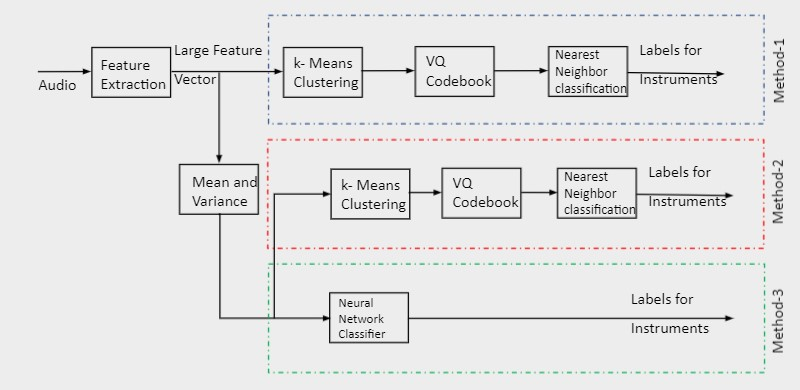

<a name = "2"></a>
#2 Method 1: 


In this method, each audio sample is divided into frames of size 30 ms, with a hop of 20 ms. 23 features are extracted from each frame. The feature list is shown below.

- MFCC Coefficients (13)
- Zero Crossing rate (1)
- Spectral Centroid (1)
- Spectral Roll off (1)
- Spectral Contrast (7)
- Short time Energy (1)

Thus 1 audio sample provides around 150 frames, and each frame has 24 columns for input features and 1 column for output label. As a result, for 11 class labels, we get many training instances. Now we club all the instances for a given class label, and reduce them using K-means clustering. K is from 32,64,128,512 and 1024. Finally, we convert the audio into frames, apply feature extraction and compare each frame with the reduced codebook, and finally classify using nearest neigbours rule.

<a name="2.1"></a>
## 2.1 Feature extraction

The features are explained in detail as follows.
- [Mel Frequency Cepstral Coefficients](https://ieeexplore.ieee.org/abstract/document/940770?casa_token=YYpeW9e5H2oAAAAA:u_n43y1uzlrPQ-nYfHMfJlkFHVDiWJx4J7hWzbNTmUL9AoBq49XWEQ42nGZgCWI4VLAcDSYoKA) (13)
  - Extraction of MFCC essentially includes windowing the signal, applying the DFT, applying a Mel frequency filter bank, and then taking the log of the magnitude followed by applying the inverse DCT as shown in figure below:

       <img src="https://drive.google.com/uc?id=1-EuUA_LI6nFdU3d9idGa-CAtfm-W7JBN" allow="autoplay"></img>

  - MFCC exploits the property that humans can not distinguish finely at higher frequencies.
- [Zero Crossing rate](https://www.researchgate.net/profile/Anu-Sharma-8/publication/304490677_Implementation_of_ZCR_and_STE_techniques_for_the_detection_of_the_voiced_and_unvoiced_signals_in_Continuous_Punjabi_Speech/links/5b960166299bf1473937e173/Implementation-of-ZCR-and-STE-techniques-for-the-detection-of-the-voiced-and-unvoiced-signals-in-Continuous-Punjabi-Speech.pdf) (1)
  - ZCR is calculated by counting number of times that time domain signal crosses zero within a short time window.
  - Can be calculated using below equation:

$ \qquad \ \ \  \ \ \ \ \ \ Z_n = \sum_{m=-\infty}^{\infty} |sgn(x[m] - sgn(x[m-1])|w[n-m]\ $ 

$ \qquad \ \ \  \ \ \ \ \ \ 
    \textsf{where, sgn(x) is the sign function and w is the window with length L} $
- [Spectral Centroid](https://books.google.co.in/books?hl=en&lr=&id=AF30yR41GIAC&oi=fnd&pg=PP9&dq=Signal+processing+methods+for+music+transcription,+Klapuri,+A.,+%26+Davy,+M.+&ots=Ootc4eQbMC&sig=9u2qdfGqWZo0O9ll7BGoSXSaqaE&redir_esc=y#v=onepage&q=Signal%20processing%20methods%20for%20music%20transcription%2C%20Klapuri%2C%20A.%2C%20%26%20Davy%2C%20M.&f=false) (1)
  - Spectral Centroid indicates the location of center of mass of spectrum and is also also associated with brightness of sound and automatic measure of musical timbre
  - Can be calculated using below equation:

$ \qquad \ \ \  \ \ \ \ \ \ F_c = \frac{\sum_{k=0}^{N-1} f(k)S(n,k)}{\sum_{k=0}^{N-1} S(n,k)}\ $ 

$ \qquad \ \ \  \ \ \ \ \ \ 
    \textsf{where, f(k) is the frequency of $n^{th}$ frame and S(n,k) is magnitude spectrum} $
    
- [Spectral Roll off](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.701.4288&rep=rep1&type=pdf) (1)
  - Spectral Roll Off is the frequency below which a specified percentage of the total spectral energy lies
  - Can be calculated using below equation:

$ \qquad \ \ \  \ \ \ \ \ \ \sum_{k=0}^{R_m} X(k) = 0.85*\sum_{k=0}^{N-1} X(k)\ $ $ \qquad \ \ \  \ \ \ \ \ \ \textsf{where, $R_m$ is spectral Roll off and X(k) is DFT magnitude of signal} $
- [Spectral Contrast](https://ieeexplore.ieee.org/abstract/document/1035731?casa_token=iv_YdX23kAoAAAAA:memlxh3EviTt5drL4Zf-kIDd97XAIj104tRx-xwZ8WYvdDkfWq9hLg2NgufHqfqheUBe3awlGg) (7)
  - Spectral Contrast considers the spectral peak, spectral valley and their difference in each sub-band.
  - Extraction of Spectral Contrast is explained in below figure:
    <img src="https://drive.google.com/uc?id=1-FkXy0tvvqvIle9pCUaS--0_Bhf8ajjS" allow="autoplay"></img>
  - Peak, Valley and Spectral Contrast is calculated as,

$ \qquad \ \ \  \ \ \ \ \ \ Peak_k = log(\frac{1}{\alpha N} \sum_{i=1}^{\alpha N} X_{k,i}),\ and\ Valley_k = log(\frac{1}{\alpha N} \sum_{i=1}^{\alpha N} X_{k,N-i+1})\ $

$ \qquad \ \ \  \ \ \ \ \ \ \ Spectral\  Contrast \ (SC_k) = Peak_k-Valley_k $ 

$ \qquad \ \ \  \ \ \ \ \ \ \textsf{Where, N is the total number of kth sub-band and $\alpha$ decides the number of neighbors to be considered for calculating Peaks and Valleys}$

- [Short time Energy](https://www.researchgate.net/profile/Anu-Sharma-8/publication/304490677_Implementation_of_ZCR_and_STE_techniques_for_the_detection_of_the_voiced_and_unvoiced_signals_in_Continuous_Punjabi_Speech/links/5b960166299bf1473937e173/Implementation-of-ZCR-and-STE-techniques-for-the-detection-of-the-voiced-and-unvoiced-signals-in-Continuous-Punjabi-Speech.pdf) (1)

  - Short Time Energy of speech signal gives information about amplitude variation.
  - Can be calculated using below given equation:

$ \qquad \ \ \  \ \ \ \ \ \ E_n = \sum_{m=-\infty}^{\infty} (x[m]w[n-m])^2\ $



The function essentially takes the audio, divides into frames with 30 ms frame length and 20 ms hop length, extracts the 24 features and then concatenates them into a dataframe to get 24 dimensional feature vector corresponding to each feature.

In [ ]:

# feature_extraction extracts features from audio and label from audio_path using librosa library

def feature_extraction(audio,audio_path):
  MFCC = librosa.feature.mfcc(audio,sr = 44100, n_mfcc = 13,hop_length = int(20*44.1),win_length=int(30*44.1)) #MFCC
  ZCR = librosa.feature.zero_crossing_rate(audio,hop_length = int(20*44.1),frame_length=int(30*44.1)) #Zero crossing rate
  SC = librosa.feature.spectral_centroid(audio,sr=44100,hop_length = int(20*44.1),win_length=int(30*44.1)) #Spectral centroid
  SRO = librosa.feature.spectral_rolloff(audio,sr = 44100, hop_length = int(20*44.1),win_length=int(30*44.1)) #Spectral roll off
  SCR = librosa.feature.spectral_contrast(audio, sr= 44100, hop_length = int(20*44.1),win_length=int(30*44.1)) #Spectral contrast
  STE = librosa.feature.rms(audio, hop_length = int(20*44.1)) #short time energy
  label = (reference_dict[re.findall("Data/(.*?)/",audio_path)[0]]) #label extraction
  label = np.repeat(np.array([label]),MFCC.shape[1],axis=0).reshape((1,-1)).astype(np.int8) #label each frame for the audio
  features = (np.concatenate((MFCC,ZCR,SC,SRO,SCR,STE,label),axis=0)).T #getting a (N x 24) dataframe for each audio, N = number of frames
  temp_df = pd.DataFrame(features)
  return temp_df

# test_feature_extraction does the same for test audio

def test_feature_extraction(audio):
  MFCC = librosa.feature.mfcc(audio,sr = 44100, n_mfcc = 13,hop_length = int(20*44.1),win_length=int(30*44.1))
  ZCR = librosa.feature.zero_crossing_rate(audio,hop_length = int(20*44.1),frame_length=int(30*44.1))
  SC = librosa.feature.spectral_centroid(audio,sr=44100,hop_length = int(20*44.1),win_length=int(30*44.1))
  SRO = librosa.feature.spectral_rolloff(audio,sr = 44100, hop_length = int(20*44.1),win_length=int(30*44.1))
  SCR = librosa.feature.spectral_contrast(audio, sr= 44100, hop_length = int(20*44.1),win_length=int(30*44.1))
  STE = librosa.feature.rms(audio, hop_length = int(20*44.1))
  mini = min(MFCC.shape[1],ZCR.shape[1],SC.shape[1],SRO.shape[1],SCR.shape[1],STE.shape[1]) #Finding the minimum number of features extracted

  #The number of frames are then trimmed so that we get equal number of frames as different features have different number of frames for test data
   
  MFCC = MFCC[:,:mini] 
  ZCR = ZCR[:,:mini]
  SC = SC[:,:mini]
  SRO = SRO[:,:mini]
  SCR = SCR[:,:mini]
  STE = STE[:,:mini]  
  features = (np.concatenate((MFCC,ZCR,SC,SRO, SCR, STE),axis=0)).T
  return features #returns features numpy array.

The following block of code is used to create a pandas dataframe using the feature extraction block for the entire training set.

In [ ]:
path = r"/content/drive/Shareddrives/EE679_Project/Dataset_Nihar/IRMAS-TrainingData"

class_paths = [os.path.join(path,i) for i in os.listdir(path)] #list of all the class paths

dataset = pd.DataFrame(index=None) #empty dataframe, to concatenate the data into

for class_path in class_paths:
  
  audio_paths = glob.glob(os.path.join(class_path,"*")) 

  for audio_path in audio_paths:
    
    temp = pd.DataFrame(index=None)
    audio,_ = librosa.load(audio_path,sr = 44100) 

    temp = feature_extraction(audio,audio_path) 

    f = [dataset, temp]

    dataset = pd.concat(f,axis = 0,ignore_index=True)

dataset.shape #The dataframe obtained finally

(1005900, 25)

Thus, we have a dataset whose shape is 1005900 (number of training instances), and 25 columns (24 features + 1 label). Lets look at our data set.

In [ ]:
dataset.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,-338.132477,160.861893,-27.298004,26.173752,-20.840553,14.958862,4.052739,18.924603,-1.768352,-8.852836,1.949183,7.005335,-3.463711,0.024943,2466.962736,5124.902344,8.197790,6.259463,13.141357,24.234183,23.543941,25.136538,29.447799,0.016915,0.0
1,-359.322418,170.962433,-22.977612,26.672104,-4.737722,14.703779,9.559379,15.872974,-0.483417,-2.502116,-7.805425,-10.944063,-12.015027,0.046107,1863.128459,3703.710938,13.385121,4.080068,13.726527,21.305708,22.751857,17.447271,36.104327,0.018311,0.0
2,-358.328522,172.585388,-26.021248,21.765724,-7.523647,21.241718,6.276466,7.511411,2.297760,-1.538653,-7.424683,-15.826614,-17.398991,0.055178,1814.274700,3100.781250,16.681179,4.259237,18.673963,16.938993,20.531060,17.800160,35.626290,0.019591,0.0
3,-335.206116,148.591095,-29.065891,44.573547,-29.152596,25.458248,7.414924,5.787493,-4.591523,-10.878541,-2.361070,-15.454148,-15.758270,0.077098,2573.371000,6007.763672,16.633251,9.184633,19.491328,18.783213,19.137112,17.530010,41.943748,0.019818,0.0
4,-296.970398,133.316269,-33.247658,56.523499,-39.696121,17.811138,-10.794838,8.169726,-12.353617,-4.996215,-2.350407,-16.476149,-8.613482,0.089947,3400.914182,7795.019531,13.413211,5.602497,12.057493,17.412548,20.224616,13.801425,41.798115,0.019743,0.0


In [ ]:
dataset.tail(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1005895,-353.550262,173.604843,-14.003283,28.088676,-4.653732,35.041710,-21.326088,2.102008,-14.796093,-0.497335,-20.455776,4.921940,5.697459,0.028723,1702.958805,2885.449219,18.641717,12.935333,17.090378,12.339082,19.618955,17.695961,35.308069,0.035506,10.0
1005896,-267.813721,105.974197,17.767824,20.268583,2.126682,23.911602,-20.919216,12.863104,-9.477929,-3.340175,-13.585569,8.794250,-15.218144,0.047619,4662.375988,12618.457031,22.557212,10.780800,15.387153,14.860358,16.446173,17.577237,39.752907,0.038193,10.0
1005897,-200.409271,75.562683,14.247360,27.275621,-10.367800,14.370339,-21.486237,5.674386,5.971552,-8.481461,-5.655194,2.333028,-10.142523,0.080121,5787.814820,11993.994141,20.186015,22.907951,18.522848,15.420557,18.361536,16.264120,42.647930,0.044441,10.0
1005898,-252.994965,144.078415,-25.377964,48.335865,-26.484192,44.940132,-32.044319,12.689090,-19.187618,-2.246316,-17.403637,5.023666,-10.270067,0.055933,3129.540280,7988.818359,18.454030,7.461043,14.413743,18.434285,16.552171,17.395519,42.008136,0.045042,10.0
1005899,-294.440948,177.681580,-32.997822,51.050419,-13.327436,35.061398,-23.625185,4.791987,-14.523028,-8.631308,-10.965881,-0.399313,-2.767048,0.046107,1902.237648,3703.710938,22.722250,6.511418,13.147616,19.750812,17.935217,17.971105,39.704682,0.039337,10.0


Thus the tail examples have labels corresponding to class 10, indicating that all the examples are converted into dataframe. Now saving the dataframe as csv file. 

In [ ]:
dataset.to_csv('/content/drive/Shareddrives/EE679_Project/Dataset_Nihar/Train/train_hop_increase.csv')

Loading the csv file as our dataset and checking it's shape.

In [ ]:
dataset = pd.read_csv('/content/drive/Shareddrives/EE679_Project/Dataset_Nihar/Train/train_hop_increase.csv',index_col=False)
dataset = dataset.iloc[:,1:]
dataset.shape

(1005900, 25)

In [ ]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,-338.132477,160.861893,-27.298004,26.173752,-20.840553,14.958862,4.052739,18.924603,-1.768352,-8.852836,1.949183,7.005335,-3.463711,0.024943,2466.962736,5124.902344,8.197790,6.259463,13.141357,24.234183,23.543941,25.136538,29.447799,0.016915,0.0
1,-359.322418,170.962433,-22.977612,26.672104,-4.737722,14.703779,9.559379,15.872974,-0.483417,-2.502116,-7.805425,-10.944063,-12.015027,0.046107,1863.128459,3703.710938,13.385121,4.080068,13.726527,21.305708,22.751857,17.447271,36.104327,0.018311,0.0
2,-358.328522,172.585388,-26.021248,21.765724,-7.523647,21.241718,6.276466,7.511411,2.297760,-1.538653,-7.424683,-15.826614,-17.398991,0.055178,1814.274700,3100.781250,16.681179,4.259237,18.673963,16.938993,20.531060,17.800160,35.626290,0.019591,0.0
3,-335.206116,148.591095,-29.065891,44.573547,-29.152596,25.458248,7.414924,5.787493,-4.591523,-10.878541,-2.361070,-15.454148,-15.758270,0.077098,2573.371000,6007.763672,16.633251,9.184633,19.491328,18.783213,19.137112,17.530010,41.943748,0.019818,0.0
4,-296.970398,133.316269,-33.247658,56.523499,-39.696121,17.811138,-10.794838,8.169726,-12.353617,-4.996215,-2.350407,-16.476149,-8.613482,0.089947,3400.914182,7795.019531,13.413211,5.602497,12.057493,17.412548,20.224616,13.801425,41.798115,0.019743,0.0


Now, we have a Big Codebook, consisting of 11 codebooks with a total of 1005900 training vectors. This will be reduced using K-means clustering to get reduced codebooks for each class, with K = 32, 64, 128, 512 and 1024. Finally comparing the results to see for which K the codebook works fine.


<a name="2.2"></a>

## 2.2 K Means Clustering 

The K Means clustering is essentially used to reduce the codebook for each class. The following function reduces the codebook using K means clustering of sklearn library. The final output is the 'codebooks' dictionary which has 11 keys as the 11 codebooks' names and the value corresponding to the key is one single codebook.

In [ ]:
def K_Means(K, dataset): #Takes the value of K and the dataset dataframe. 
  codebooks = {
      "gac" : np.zeros((K,16)),
      "cel" : np.zeros((K,16)),
      "flu" : np.zeros((K,16)),
      "cla" : np.zeros((K,16)),
      "org" : np.zeros((K,16)),
      "pia" : np.zeros((K,16)),
      "sax" : np.zeros((K,16)),
      "tru" : np.zeros((K,16)),
      "vio" : np.zeros((K,16)),
      "voi" : np.zeros((K,16)),
      "gel" : np.zeros((K,16))
  }

  for i in range(0,11):
    temp_codebook = dataset.loc[dataset["24"]==i].values
    temp_codebook_2 = temp_codebook[:,:-1]

    KMM = sklearn.cluster.KMeans(n_clusters = K,n_init=10,max_iter=500)
   
    KMM.fit(temp_codebook_2)
    print("Codebook reduced : ",i)
    TEMP_CODEBOOK = KMM.cluster_centers_
    codebooks[list(reference_dict.keys())[i]] = TEMP_CODEBOOK
  return codebooks #returns the codebooks dictionary

<a name="2.3"></a>
## 2.3 Nearest Neighbours

The nearest neigbours rule essentially is used to assign each of the test vector to one of the eleven classes. This is done by considering the minimum distance between the test vector and each of the training vector codeword obtained after K means clustering. Two functions, model_fit and model_transform create codebook for a given value of 'K' and create confusion matrix, return accuracy respectively. 

In [ ]:
def model_fit(Train_set,K,store_path): #Creates pickle file for storing the codebooks for a given value of 'K' from a 'Train set'
  K_codebook = K_Means(K,Train_set)

  filename = store_path + "/" + "codebook_" + str(K)

  with open(filename, 'wb') as handle:
    pickle.dump(K_codebook, handle, protocol=pickle.HIGHEST_PROTOCOL)
  return K_codebook #Returns codebook for a value of 'K'

def model_transform(K,K_codebook,directory_for_test):  #Returns Confusion Matrix and accuracy 
  CM, accuracy = K_NN(K,K_codebook,directory_for_test) 
  return CM, accuracy 

The K_NN function is used to predict the class for test data. The major issue faced here is that the test data has multiple classes for each sample. The labels can be one, two, three, four or more than four. So the way to calculate accuracy for such a test data is mentioned in the form of algorithm given below.

- The test sample is windowed and features are extracted.
- Each test vector from test sample is taken and euclidean distance is calculated between the particular test vector and each of the training codeword (for K = 32, there will be total 32*11 = 352 codewords).
- The codeword from which the distance is minimum, the test vector is assigned the class of the codeword.
- This process is replicated for each of the test vectors, and the class to which maximum test vectors belong to, is labelled as class of the test sample.
  - Say a test example is split into 300 test vectors, and 50 of them belong to class 0, 150 of them belong to class 1, 60 belong to class 2, 40 to class 3, and 0 to other classes, then the test sample is labelled as class 1.

- After the class is predicted, the output is then converted into a sparse vector form, which is 1 at the index of the class and 0 elsewhere. E.g. if output belongs to class 4, output vector is [0 0 0 0 1 0 0 0 0 0 0].
- Similarly the output being multilabel, is converted into a sparse vector as well. i.e. if output has labels 'gel', 'voi' and 'vio', it is converted into :    
[0 0 0 0 0 1 0 1 1 0 0] 
- Finally, the way to determine if the predicted class is true or not, we use the following rule.
  - If either one of the output classes is predicted true, the sample is counted as correctly classified.
  - If none of the output classes is predicted true, the sample will correspond to 'n' number of incorrectly classified sample. E.g. if the class has 3 labels and output prediction doesn't contain either of them, then the sample is said to contribute towards 3 incorrect samples.

- Thus, accuracy is given by :    
  Accuracy = $\frac{Correct}{Total}$
- The Confusion Matrix is also obtained.

In [ ]:
def K_NN(K,K_codebook,directory_for_test): #Uses nearest neigbours rule to determine class for each of the test sample is 'directory_for_test'
  
  test_paths = sorted(os.listdir(directory_for_test))

  total = 0
  correct = 0
  ConfusionMatrix = []
  for temp_path in test_paths:
    if '.txt' in temp_path:
      text_label = open(directory_for_test + "/" + temp_path, mode='r').read()
      # text_label = text_label.split("\t")[0]
      # text_label = reference_dict[text_label]
      text_label = text_label.split("\t\n")
      label_vector = np.zeros((1,11))
      for i in text_label:
        if i != "":
          tl = reference_dict[i]
          label_vector[0,tl] = 1
      
      text_label = pd.DataFrame(label_vector)
    elif '.wav' in temp_path:
      audio_test,_ = librosa.load(directory_for_test + "/" + temp_path,sr=44100)
      X = test_feature_extraction(audio_test)
      P_vector = predict_class_probabilities(K,X,K_codebook)
      # P_class = np.where(P_vector == np.max(P_vector,axis=1))[1][0]
      # if P_class == text_label:
      #   accurate_samples = accurate_samples + 1
      Y_pred = P_vector
      _,counts = np.unique(label_vector,return_counts=True)
      l = counts[1]
      Y_pred_bin = np.where(Y_pred == np.max(Y_pred),1,0)
      
      Q= np.round(np.linalg.norm(label_vector - Y_pred_bin)**2,2)
      
      #print(np.where(label_vector==np.max(label_vector)),np.where(Y_pred_bin==np.max(Y_pred_bin)))
      if l == 1:
        j = np.where(label_vector==np.max(label_vector))[1][0]
        x = np.where(Y_pred_bin==np.max(Y_pred_bin))[1][0]
        ConfusionMatrix.append((j,x))
      elif l == 2:
        
        j,k = np.where(label_vector==np.max(label_vector))[1]
        x = np.where(Y_pred_bin==np.max(Y_pred_bin))[1][0]
        ConfusionMatrix.append((j,x))
        ConfusionMatrix.append((k,x))
      elif l == 3:
        j,k,r = np.where(label_vector==np.max(label_vector))[1]
        x = np.where(Y_pred_bin==np.max(Y_pred_bin))[1][0]
        ConfusionMatrix.append((j,x))
        ConfusionMatrix.append((k,x))
        ConfusionMatrix.append((r,x))
      elif l == 4:
        j,k,r,s = np.where(label_vector==np.max(label_vector))[1]
        x = np.where(Y_pred_bin==np.max(Y_pred_bin))[1][0]
        ConfusionMatrix.append((j,x))
        ConfusionMatrix.append((k,x))
        ConfusionMatrix.append((r,x))
        ConfusionMatrix.append((s,x))
      else:
        print("Too many samples 1 in this example")
      
      if Q < l:
        correct = correct + 1
      
      total = total + 1
  print("Total samples : ",total," Correct samples : ",correct, " Accuracy = ",correct/total)
        
  return ConfusionMatrix, 100*correct / total

The following function "predict_class_probabilities" predicts the class for a given sample using the algorithm mentioned earlier. The output is a vector where the value at each index is the number of test vectors of test samples corresponding to the class. 

In [ ]:
def softmax(vector):
	e = np.exp(vector)
	return e / e.sum()

def predict_class_probabilities(K,X,Train_set):

    class_test = np.zeros((1,11))
    for k in range(0,X.shape[0]):
      d_min = np.zeros((1,11))
      x = X[k,:].reshape((1,-1))
      x_vec = np.repeat(x,K,axis=0)
      # print(x.shape,x_vec.shape)
      j = 0
      for i in ['gac', 'tru', 'flu', 'pia', 'cla', 'voi', 'org', 'vio', 'gel', 'sax', 'cel']:
        y = (Train_set[i])
        d = np.sum((x_vec-y)**2,axis=1) 
        d_min[0,j] = np.min(d)
        j = j + 1
      #print(d_min)
      class_test_temp = np.where(d_min == np.min(d_min),1,0)
      class_test = class_test + class_test_temp 

    return class_test #This is the index of the class

In [ ]:
def plot_Confusion(CM):
  CM_arr_new = np.zeros((11,11))

  for i in CM:
    CM_arr_new[i[0],i[1]]+=1

  print(CM_arr_new)

  g = ['gac', 'tru', 'flu', 'pia', 'cla', 'voi', 'org', 'vio', 'gel', 'sax','cel']

  sns.heatmap(CM_arr_new,annot=True,xticklabels = g,yticklabels = g,cmap="coolwarm",fmt=".3g")
  plt.title("Confusion Matrix for first test Set")
  plt.xlabel("True values")
  plt.ylabel("Predicted values")
  return CM_arr_new

<a name = "2.4"></a>
## 2.4 Testing the model

This codeblock is for the other values of 'K', i.e. 64 and 1024. Due to the time taken for execution of codebook preparation and comparison, we had to make use of multiple colab books. As a result, the following codeblock was trained on seperate colab notebook.

The below codeblock is taken from one of the colab notebooks prepared by us for K = 64, 1024

In [ ]:
directory_for_test = r"/content/drive/Shareddrives/EE679_Project/Dataset_Nihar/IRMAS-TestingData-Part1/IRMAS-TestingData-Part1/Part1"

storepath = r"/content/drive/Shareddrives/EE679_Project/K_codebooks"

acc = [0,0]
count = 0
CM = [0,0]

for i in [64,1024]:
      
  #curr_codebook = model_fit(dataset, i, storepath)
  filename = storepath + "/codebook_" + str(i)
  
  #During first run time, we created the codebook and stored in pickle file
  #During second run time, we used the loading of pickle file

  with open(filename, 'rb') as handle:
    curr_codebook  = pickle.load(handle)


  CM[count], acc[count] = model_transform(i,curr_codebook,directory_for_test)
  
  print("For K = ",i,"Accuracy : ",acc[count])
  count = count + 1

Total samples :  807  Correct samples :  268  Accuracy =  0.33209417596034696
For K =  64 Accuracy :  33.2094175960347
Total samples :  807  Correct samples :  371  Accuracy =  0.459727385377943
For K =  1024 Accuracy :  45.9727385377943


Below, we plotted the Confusion Matrix, for K = 1024

[[ 64.   1.   2.   5.  14.  41.   5.   0.   9.   2.   2.]
 [  6.   0.   7.   7.  10.  15.  12.   1.  19.   2.   0.]
 [  0.   0.   1.   0.   6.   6.   9.   0.   6.   0.   0.]
 [ 45.   6.  19.  76.  17.  74.  68.   5.  44.  10.   3.]
 [  1.   3.   0.   1.   1.   0.   0.   0.   0.   2.   0.]
 [ 16.   3.   8.  14.  10.  70.  23.   1.  74.   0.  10.]
 [  4.   2.   4.   4.   1.  23.  34.   1.  17.   1.   0.]
 [ 17.   0.   4.   0.   8.  15.   2.   0.   4.   0.   1.]
 [  8.   4.   4.  24.   1.  38.  30.   2. 116.   6.   8.]
 [ 11.   2.   7.  26.   8.  62.  23.   0.  17.  10.   1.]
 [  3.   0.   5.   1.   6.   8.   2.   0.   0.   0.   1.]]


Text(33.0, 0.5, 'Predicted values')

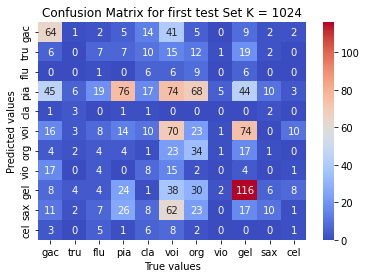

In [ ]:
confusion = plot_Confusion(CM[1])


g = ['gac', 'tru', 'flu', 'pia', 'cla', 'voi', 'org', 'vio', 'gel', 'sax','cel']

sns.heatmap(confusion,annot=True,xticklabels = g,yticklabels = g,cmap="coolwarm",fmt=".3g")
plt.title("Confusion Matrix for first test Set K = 1024")
plt.xlabel("True values")
plt.ylabel("Predicted values")

Now, we have merged the codeblock from other colab notebook where we obtained the confusion matrix for K = 512. Also the accuracy for K = 32, 128 and 512.

In [ ]:
directory_for_test = r"/content/drive/Shareddrives/EE679_Project/Dataset_Nihar/IRMAS-TestingData-Part1/IRMAS-TestingData-Part1/Part1"

storepath = r"/content/drive/Shareddrives/EE679_Project/K_codebooks"

acc = [0,0,0]
CM = [0,0,0]
count = 0

for i in [32,128,512]:
  
  filename = storepath + "/codebook_" + str(i)
  #curr_codebook = model_fit(dataset, i, storepath)
  with open(filename, 'rb') as handle:
    curr_codebook  = pickle.load(handle)

  CM[count],acc[count] = model_transform(i,curr_codebook,directory_for_test)
  
  print("For K = ",i,"Accuracy : ",acc[count])
  
  count = count + 1

Total samples :  807  Correct samples :  240  Accuracy =  0.29739776951672864
For K =  32 Accuracy :  29.739776951672862
Total samples :  807  Correct samples :  322  Accuracy =  0.3990086741016109
For K =  128 Accuracy :  39.90086741016109
Total samples :  807  Correct samples :  350  Accuracy =  0.43370508054522927
For K =  512 Accuracy :  43.37050805452292


[[ 64.   1.   2.   5.  14.  41.   5.   0.   9.   2.   2.]
 [  6.   0.   7.   7.  10.  15.  12.   1.  19.   2.   0.]
 [  0.   0.   1.   0.   6.   6.   9.   0.   6.   0.   0.]
 [ 45.   6.  19.  76.  17.  74.  68.   5.  44.  10.   3.]
 [  1.   3.   0.   1.   1.   0.   0.   0.   0.   2.   0.]
 [ 16.   3.   8.  14.  10.  70.  23.   1.  74.   0.  10.]
 [  4.   2.   4.   4.   1.  23.  34.   1.  17.   1.   0.]
 [ 17.   0.   4.   0.   8.  15.   2.   0.   4.   0.   1.]
 [  8.   4.   4.  24.   1.  38.  30.   2. 116.   6.   8.]
 [ 11.   2.   7.  26.   8.  62.  23.   0.  17.  10.   1.]
 [  3.   0.   5.   1.   6.   8.   2.   0.   0.   0.   1.]]


Text(33.0, 0.5, 'Predicted values')

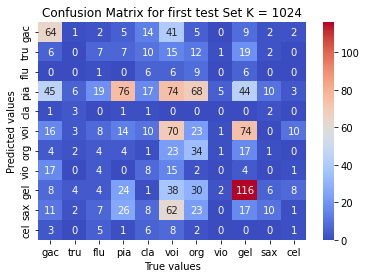

In [ ]:
confusion = plot_Confusion(CM[1])


g = ['gac', 'tru', 'flu', 'pia', 'cla', 'voi', 'org', 'vio', 'gel', 'sax','cel']

sns.heatmap(confusion,annot=True,xticklabels = g,yticklabels = g,cmap="coolwarm",fmt=".3g")
plt.title("Confusion Matrix for first test Set K = 1024")
plt.xlabel("True values")
plt.ylabel("Predicted values")

<a name="2.5"></a>

## 2.5 Confusion matrix observation : 
- As evident from the above two codebooks, we can see that 'gel' i.e. electric guitar class has highest number of true positives, followed by piano, voiced and 'gac' i.e. acoustic guitar. 
- The non zero non diagonal elements indicate which instrument gets misclassified into which instrument. From above confusion matrix, K = 1024, the maximum misclassification is from different instruments into Piano class, highest being voiced getting classified into piano class.
- The zero non diagonal elements indicate that the given instrument on x axis will not be classified into corresponding instrument on y axis. For instance, Saxophone is not classified as violin by the predictor.

<a name="2.6"></a>
## 2.6 Accuracy vs 'K' plot

The following codeblock firstly creates the dictionary with accuracy values obtained in the results section. Since we used multiple colab notebooks to train the model, we had to write the accuracy values manually in the dictionary. Using plotly.express, we plotted the "Accuracy" vs "Number of clusters K" plot.

In [ ]:
final_plot={
"Accuracy (%)" : np.array([29.72,33.20,39.90,43.37,45.97]),
"Number of clusters K" : np.array([32,64,128,512,1024])
}
final_plot = pd.DataFrame(final_plot)

fig2 = go.Figure(go.Scatter(x=final_plot["Number of clusters K"],y=final_plot["Accuracy (%)"],
                    mode='lines+markers',fillcolor="green"))
fig2.update_layout(
    title="Accuracy vs Number of clusters : K",
    xaxis_title="Number of clusters K",
    yaxis_title="Accuracy (%)",
    colorway=["green"]
)

fig2.show()

As we can see, the accuracy rises steeply till K=128, then it rises slowly.

<a name="2.7"></a>

## 2.7 Model observations

- The codebook matching yielded accuracy as shown in the plot in the section 2.6, as the value of K went on increasing, the accuracy kept on increasing. However the accuracy did not improve much after K = 128. 

- Time for model training kept on increasing as 'K' kept on increasing. 


<a name="3"></a>
#3 Method 2

For this method, we follow the same procedure as the Method 1, with one modification. For a single training audio sample, we take the average and variance of all the features and concatenate them to get a 48 dimensional vector. Thus for 6507 examples, we have 6507 training vectors.

After that, all the steps are similar to the Method 1, like K Means clustering to get the codebooks, and nearest neigbours rule to get the prediction vector.


<a name="3.1"></a>
## 3.1 Feature extraction and importance

Now, lets look at the mean and variance of each features. For this purpose, we use the codebook for K = 32 prepared in method 1. We want to look at the mean and variance of different features. 

In [ ]:
filename = r"/content/drive/Shareddrives/EE679_Project/K_codebooks/codebook_32"

with open(filename, 'rb') as handle:
    codebook_plot = pickle.load(handle) 

We converted the codebook into dataframe, 352 total vectors, and 25 columns.

In [ ]:
final_df = pd.DataFrame()

for x in codebook_plot.keys():
  temp = pd.DataFrame(codebook_plot[x])
  temp["24"] = reference_dict[x]
  final_df = pd.concat([final_df,temp],axis=0,ignore_index=True)
final_df.shape

(352, 25)

In [ ]:
final_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,-395.265707,208.778252,9.493546,12.804020,15.206564,7.189550,1.489533,3.181159,-2.611859,-4.550728,-7.734624,-6.516383,-4.502795,0.019264,904.917395,1380.755791,15.394055,10.342113,16.795185,19.602904,20.341133,22.029281,30.026305,0.060437,0
1,-230.021732,135.090284,-15.919783,59.463178,-14.294322,30.483220,-9.503379,15.378565,-4.576040,5.152762,-5.442260,-0.329368,-4.676125,0.049963,2824.419536,6886.611496,15.404313,9.396689,14.169179,16.687475,16.825386,17.658657,44.022815,0.099017,0
2,-190.663037,148.722019,16.466700,9.523739,29.929198,-13.591377,29.175094,-14.461013,18.335901,-0.582662,3.895558,4.050985,-0.867499,0.099905,4681.518640,16575.448649,13.879277,9.389554,13.283087,16.686673,17.888429,18.714372,27.920865,0.149297,0
3,-295.894906,181.761803,-30.766894,40.426856,4.507538,11.147233,-1.601103,6.973121,-1.543161,-1.141005,-4.501776,-3.029279,-3.323379,0.035063,1631.226448,3217.151434,16.878455,9.949752,15.338670,18.711145,19.565820,22.151224,37.970377,0.078260,0
4,-158.516456,100.440738,-31.189828,62.251961,-30.254554,37.815805,-24.394379,23.365108,-17.089808,12.708395,-11.871999,3.890034,-8.648528,0.129328,4844.654128,10109.794438,16.252038,9.194516,13.269790,15.455905,15.861420,17.345897,49.102405,0.095899,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,-186.075484,176.895943,-44.632021,54.778772,1.191396,16.826017,-2.859912,9.638167,-0.949847,2.828891,2.349997,-1.667521,1.179579,0.041562,1889.806648,3972.973119,13.990695,9.267878,14.335980,17.082944,17.499023,19.361329,43.068732,0.165087,8
348,-131.398396,108.121053,-11.241513,45.403773,-4.615121,41.660053,-23.931509,29.663950,-20.533205,21.802541,-12.060585,13.541557,-5.738357,0.083135,4342.437875,11259.751403,13.211763,9.432469,13.841881,16.537095,17.435924,17.896564,46.819248,0.181317,8
349,-138.876765,121.016256,-17.778434,53.743732,-14.684108,40.548737,-20.463569,24.010427,-14.132022,15.318301,-8.202105,7.254581,-3.422601,0.070842,3674.551415,9089.582847,13.446991,9.108515,13.512624,16.151264,16.892353,17.212858,46.641452,0.168275,8
350,-182.896419,133.618613,-12.646809,61.110567,-18.458476,41.504221,-12.077119,14.860801,-7.548740,7.296514,-4.909833,3.165822,-0.935002,0.049013,2897.789719,7372.592513,14.067766,9.432306,14.501917,16.477681,17.303700,16.920007,46.376847,0.144797,8


Below is the plot for probability density function of each and every feature for the 11 distinct classes and the K = 32 codebook we obtained.

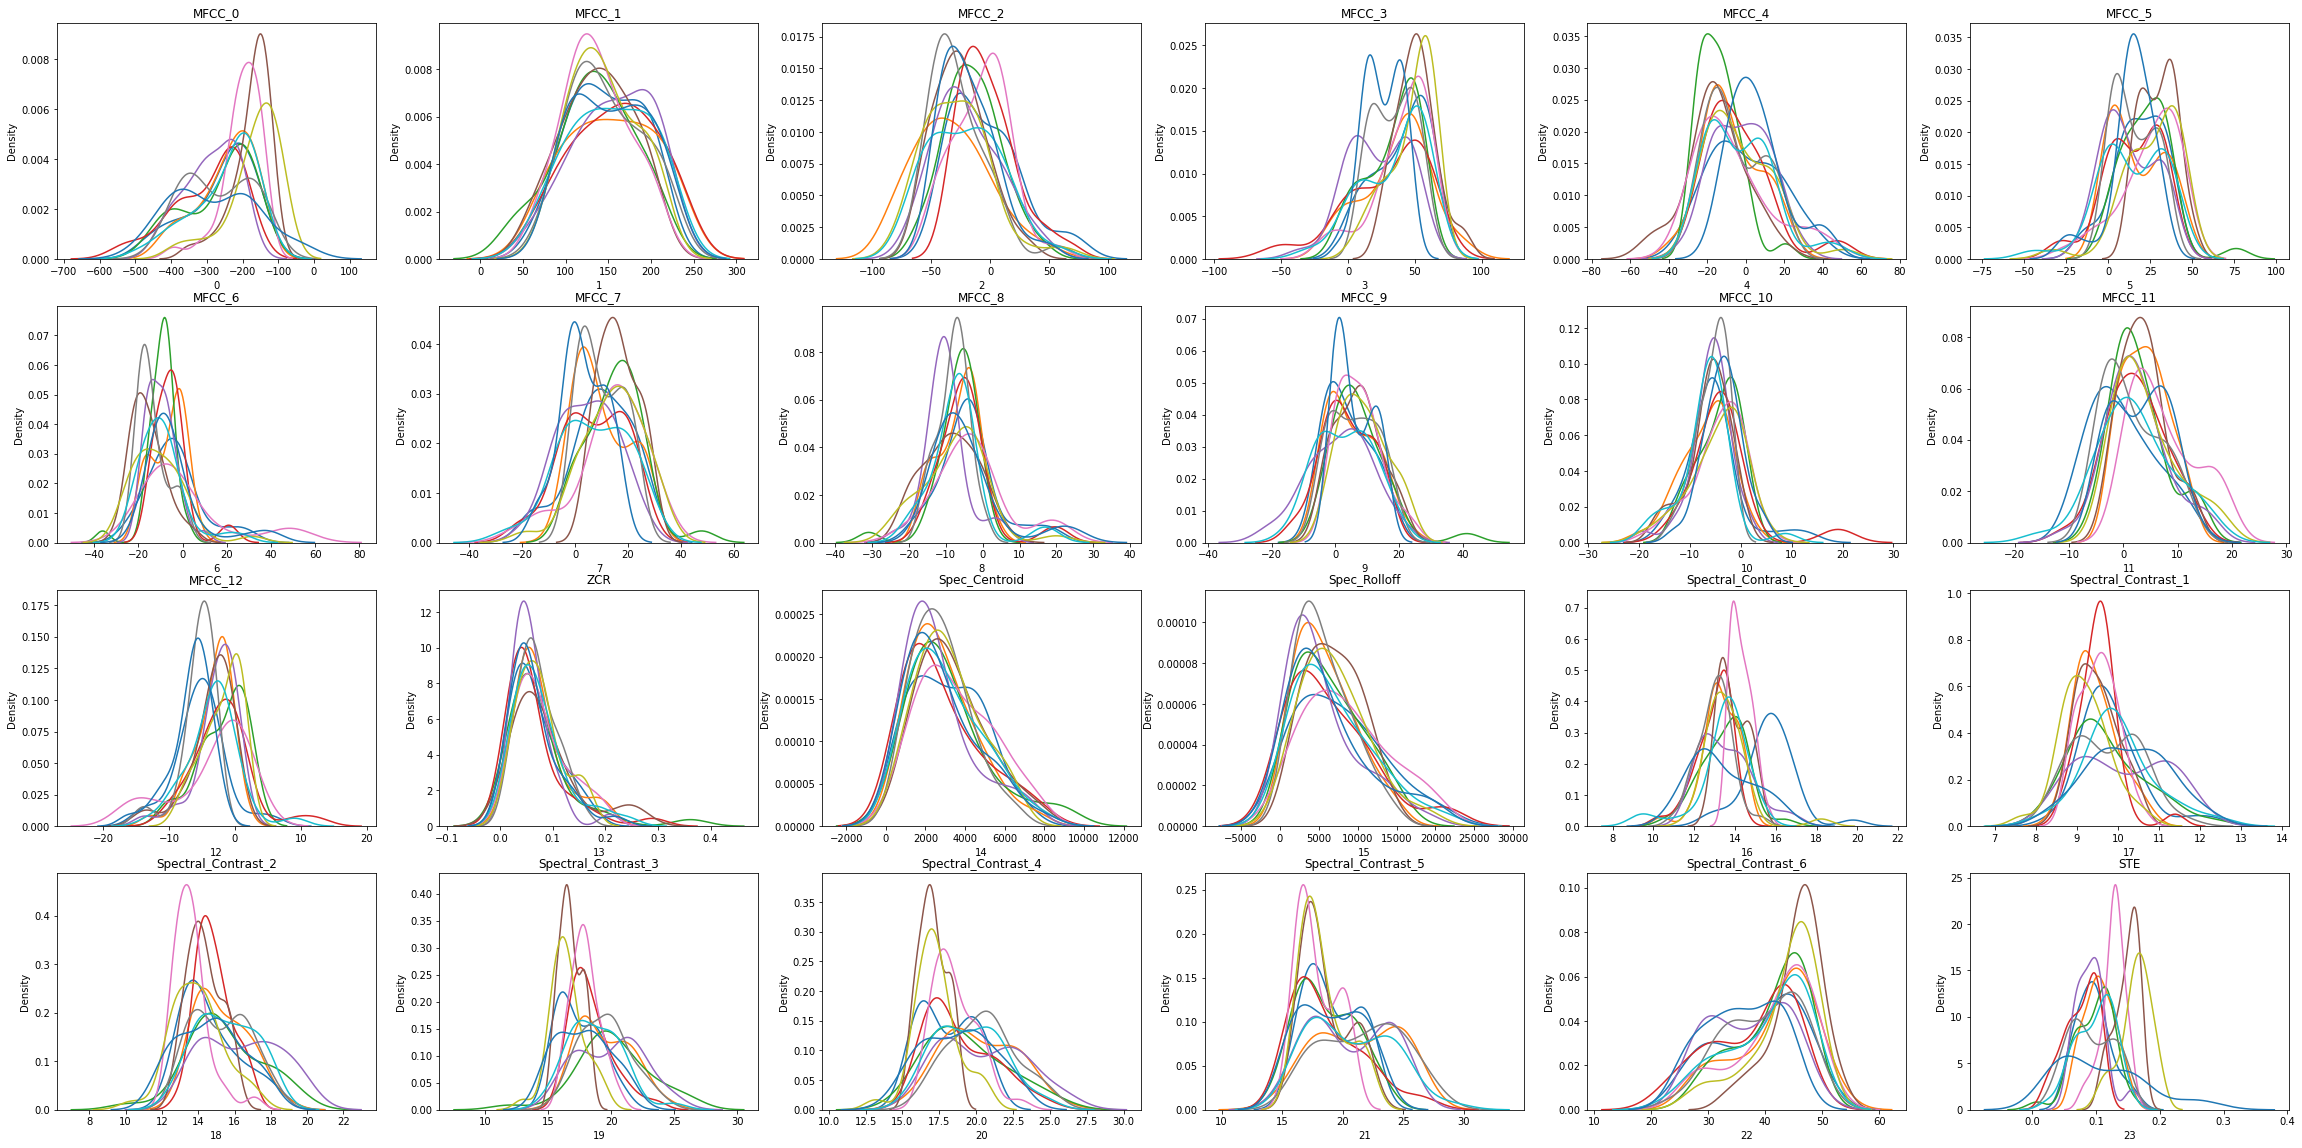

In [ ]:
import warnings
warnings.filterwarnings("ignore")

figure = plt.figure(figsize=(40,20))
mfcc_1 = [0,0,0,0,0,0,0,0,0,0,0]

mfcc_features = ["MFCC_"+str(i) for i in range(0,13)]
spec_features = ["Spectral_Contrast_"+str(i) for i in range(0,7)]
features = [*mfcc_features,"ZCR","Spec_Centroid","Spec_Rolloff",*spec_features,"STE"]

for j in range(0,24):
  
  figure.add_subplot(4,6,1+j)
  plt.title(features[j])
  for i in range(0,11):

    mfcc_1[i] = final_df[final_df["24"]==i][j]

    
    sns.distplot(mfcc_1[i],hist=False)

plt.show()

It can be seen that mean and variance of different coloured curves are different. Thus we can use the mean and variance of each audio sample's feature as a new feature itself. 

Now we extract the features and find their mean and variance and concatenate them to create a giant 48 dimensional vector.

In [ ]:
def feature_extraction(audio,audio_path): #Extracts features just like the method 1
  MFCC = librosa.feature.mfcc(audio,sr = 44100, n_mfcc = 13,hop_length = int(20*44.1),win_length=int(30*44.1))
  ZCR = librosa.feature.zero_crossing_rate(audio,hop_length = int(20*44.1),frame_length=int(30*44.1))
  SC = librosa.feature.spectral_centroid(audio,sr=44100,hop_length = int(20*44.1),win_length=int(30*44.1))
  SRO = librosa.feature.spectral_rolloff(audio,sr = 44100, hop_length = int(20*44.1),win_length=int(30*44.1))
  SCR = librosa.feature.spectral_contrast(audio, sr= 44100, hop_length = int(20*44.1),win_length=int(30*44.1))
  STE = librosa.feature.rms(audio, hop_length = int(20*44.1))
  label = (reference_dict[re.findall("Data/(.*?)/",audio_path)[0]])
  label = pd.DataFrame(np.repeat(np.array([label]),1,axis=0).reshape((1,-1)).astype(np.int8))
  features = (np.concatenate((MFCC,ZCR,SC,SRO,SCR,STE),axis=0)).T
  temp_df = pd.DataFrame(features)
  temp_df_mean = temp_df.mean(axis=0)
  temp_df_variance = temp_df.var(axis=0)

  # One new step is to take the mean and variance of the features across the frames, and find their average and variance.
  # Concatenating them to get temp_df_new
  temp_df_new = pd.concat([temp_df_mean,temp_df_variance,label],axis=0).values.reshape((1,-1)) 
  temp_df_new = pd.DataFrame(temp_df_new)
  return temp_df_new

def test_feature_extraction(audio): #Extracts features for test samples
  MFCC = librosa.feature.mfcc(audio,sr = 44100, n_mfcc = 13,hop_length = int(20*44.1),win_length=int(30*44.1))
  ZCR = librosa.feature.zero_crossing_rate(audio,hop_length = int(20*44.1),frame_length=int(30*44.1))
  SC = librosa.feature.spectral_centroid(audio,sr=44100,hop_length = int(20*44.1),win_length=int(30*44.1))
  SRO = librosa.feature.spectral_rolloff(audio,sr = 44100, hop_length = int(20*44.1),win_length=int(30*44.1))
  SCR = librosa.feature.spectral_contrast(audio, sr= 44100, hop_length = int(20*44.1),win_length=int(30*44.1))
  STE = librosa.feature.rms(audio, hop_length = int(20*44.1))
  mini = min(MFCC.shape[1],ZCR.shape[1],SC.shape[1],SRO.shape[1],SCR.shape[1],STE.shape[1])

  MFCC = MFCC[:,:mini]
  ZCR = ZCR[:,:mini]
  SC = SC[:,:mini]
  SRO = SRO[:,:mini]
  SCR = SCR[:,:mini]
  STE = STE[:,:mini]  

  features = (np.concatenate((MFCC,ZCR,SC,SRO, SCR, STE),axis=0)).T
  temp_df = pd.DataFrame(features)
  temp_df_mean = temp_df.mean(axis=0)
  temp_df_variance = temp_df.var(axis=0)

  # Similar to the feature_extraction function.

  temp_df_new = pd.concat([temp_df_mean,temp_df_variance],axis=0).values.reshape((1,-1))
  temp_df_new = pd.DataFrame(temp_df_new)
  features_new = temp_df_new.values

  return features_new

Similar dataset preparation like Method 1.

In [ ]:
path = r"/content/drive/Shareddrives/EE679_Project/Dataset_Nihar/IRMAS-TrainingData"

class_paths = [os.path.join(path,i) for i in os.listdir(path)]

dataset = pd.DataFrame(index=None)

for class_path in class_paths:
  
  audio_paths = glob.glob(os.path.join(class_path,"*")) 

  for audio_path in audio_paths:
    
    temp = pd.DataFrame(index=None)
    audio,_ = librosa.load(audio_path,sr = 44100) 

    temp = feature_extraction(audio,audio_path) 

    f = [dataset, temp]

    dataset = pd.concat(f,axis = 0,ignore_index=True)

dataset.shape 

(6706, 49)

In [ ]:
dataset.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,-335.192113,170.935225,-19.454642,33.292858,-14.380249,18.788046,-3.264780,6.110534,-2.344570,1.582163,-0.841037,-3.592079,-3.401673,0.039985,1963.225851,4034.748047,15.728552,9.201063,13.943738,17.177974,18.163309,17.386984,37.465986,0.030840,1262.235274,385.056782,122.548566,302.889671,134.504371,128.455650,91.991667,66.727958,45.911203,67.343468,65.171997,42.432432,51.308803,0.000366,407854.147040,3.247965e+06,26.840831,14.698182,13.538478,20.170645,9.768942,8.424589,12.198517,0.000266,0.0
1,-334.413796,175.707016,-20.157610,36.810959,-14.500996,20.794908,-2.906958,14.872066,-2.845726,0.691500,-3.621174,-3.156589,-0.400171,0.038342,1903.469321,3881.575195,16.873510,7.705517,13.475022,17.972515,17.752697,16.648654,37.028456,0.029476,928.463504,306.124893,78.730488,157.226924,117.569969,71.847397,54.218251,57.986865,63.418702,69.021282,52.301923,55.606978,40.962097,0.000293,325337.063028,2.560618e+06,23.823365,9.347435,10.946074,16.553727,10.166070,5.952365,10.326645,0.000205,0.0
2,-294.908233,174.328383,-44.161287,65.382548,-13.144773,8.862502,-4.548976,8.991158,-4.215441,-7.663027,-1.975484,0.051910,0.841532,0.041733,2032.623899,4604.085938,18.374806,12.873110,12.997654,19.950476,21.128877,23.932884,41.448832,0.049812,613.680639,331.616187,69.317864,72.762088,219.839965,144.797709,81.224126,71.951960,41.424807,79.271770,53.920734,69.956511,57.962929,0.000280,287201.705779,1.812109e+06,24.208067,12.955744,17.149497,11.875978,9.751825,9.833642,7.536779,0.000068,0.0
3,-297.599439,170.397420,-38.002063,62.306802,-1.863208,8.139100,-5.709397,8.955572,7.222137,-2.124034,-10.722810,-13.565956,-3.060452,0.036513,1872.348308,4089.155273,20.106762,10.813405,16.622488,20.447334,21.042408,23.446756,40.822347,0.059539,832.217668,358.367591,129.043316,132.810117,240.668124,201.328853,116.633674,80.367252,40.473501,58.562384,105.871096,107.014806,32.774814,0.000401,312639.142147,1.859712e+06,29.612276,12.972241,18.783177,11.218996,10.187477,10.054959,12.803761,0.000324,0.0
4,-303.210821,183.401398,18.878688,16.167329,18.940007,11.480280,1.132372,0.189567,2.279365,-3.625814,-2.602948,-7.003162,-8.941121,0.022479,832.631619,1453.921875,16.001868,11.430818,18.873130,18.957196,20.218535,25.868585,28.059307,0.176067,11771.145333,2330.477653,2403.270996,654.484951,340.086916,207.277304,243.779173,96.883706,104.022777,49.288521,62.900679,70.816209,66.818690,0.000232,294679.945681,1.503880e+06,43.018651,16.649103,23.778367,36.188911,19.304817,101.650661,125.978332,0.014966,0.0


In [ ]:
dataset.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
6701,-272.658325,196.349564,-18.822216,24.805344,13.646932,16.495258,-14.873262,11.582706,-5.044127,3.544765,-8.973026,-6.628332,-2.164388,0.022736,1432.556769,2960.384766,21.881845,11.162800,15.120322,16.729280,17.580515,21.246124,35.656793,0.093846,1489.112181,830.476156,115.695750,211.725136,223.310916,94.338500,57.243054,76.462079,54.696934,72.200547,61.340198,32.503011,26.224329,0.000084,3.762264e+05,2.958263e+06,24.369886,12.779647,12.241889,13.467844,8.180659,14.118379,18.124431,0.000332,10.0
6702,-124.979225,216.936702,-63.447808,25.814352,25.160195,7.036821,-11.302308,2.017085,-8.451351,4.616366,-3.071550,-0.085092,-3.464306,0.042842,1572.072576,2963.112305,22.086257,9.099875,12.051699,14.220053,15.489935,20.527772,39.976726,0.279589,480.047129,45.796071,158.306869,54.337561,103.489669,95.339276,27.709171,45.999443,34.821214,39.546314,35.407293,50.581193,34.029469,0.000221,4.323087e+04,9.714163e+04,28.150491,10.227996,12.744185,8.556119,5.628295,4.942258,9.790438,0.002990,10.0
6703,-231.575459,189.775949,-30.675166,34.130192,10.608232,20.741040,-15.982825,10.805017,-7.282350,4.681682,-9.750056,-10.419179,-8.100327,0.030229,1605.494672,3232.564453,19.563804,10.837786,17.617339,16.666945,18.644608,20.724888,38.725768,0.108936,681.628437,539.307047,72.190544,156.417785,95.070373,94.120921,69.570920,46.713401,69.270900,50.016534,58.015300,38.996114,44.597220,0.000068,2.806441e+05,2.187661e+06,24.134931,13.711358,15.291228,12.480791,7.593075,12.554640,8.408973,0.000556,10.0
6704,-324.121025,188.727023,-5.894366,31.285495,-18.749854,23.159438,-10.023206,19.218701,4.591904,9.524495,-4.413641,2.710364,-1.012827,0.029413,1858.721403,3602.791992,18.883518,8.426001,11.105413,14.856022,15.179104,16.320746,36.208974,0.039550,1659.514445,1262.425507,439.959673,123.079172,97.649074,103.858587,97.684765,74.488795,65.935507,55.900448,45.316417,50.345666,64.611775,0.000391,1.574824e+06,1.013831e+07,18.746055,10.915657,10.778355,12.084611,6.698096,8.431547,11.670732,0.000046,10.0
6705,-345.809147,182.278903,-16.609005,31.414567,-9.660581,18.422349,-14.222140,7.155413,-1.799620,1.241460,-10.349769,-1.587678,-4.211301,0.029448,1840.372885,3741.465820,22.619530,11.230487,14.346048,17.126183,16.841023,17.702715,35.699447,0.032314,1363.917431,935.555268,214.849041,79.558169,100.062143,73.329318,99.556967,145.915988,103.943168,64.488716,70.428748,54.015142,85.762381,0.000269,1.206139e+06,7.896095e+06,23.215450,13.739437,14.753800,14.300803,7.050296,5.858693,9.112224,0.000036,10.0


Now, we have a Big Codebook, consisting of 11 codebooks with a total of 6706 training vectors, and number of columns = 48 features + 1 label = 49.


In [ ]:
dataset.to_csv('/content/drive/Shareddrives/EE679_Project/Dataset_Nihar/Train/train_mean_var.csv')

In [ ]:
dataset = pd.read_csv('/content/drive/Shareddrives/EE679_Project/Dataset_Nihar/Train/train_mean_var.csv',index_col=False)
dataset = dataset.iloc[:,1:]
dataset.shape

(6706, 49)

In [ ]:
dataset.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
6701,-272.658325,196.349564,-18.822216,24.805344,13.646932,16.495258,-14.873262,11.582706,-5.044127,3.544765,-8.973026,-6.628332,-2.164388,0.022736,1432.556769,2960.384766,21.881845,11.162800,15.120322,16.729280,17.580515,21.246124,35.656793,0.093846,1489.112181,830.476156,115.695750,211.725136,223.310916,94.338500,57.243054,76.462079,54.696934,72.200547,61.340198,32.503011,26.224329,0.000084,3.762264e+05,2.958263e+06,24.369886,12.779647,12.241889,13.467844,8.180659,14.118379,18.124431,0.000332,10.0
6702,-124.979225,216.936702,-63.447808,25.814352,25.160195,7.036821,-11.302308,2.017085,-8.451351,4.616366,-3.071550,-0.085092,-3.464306,0.042842,1572.072576,2963.112305,22.086257,9.099875,12.051699,14.220053,15.489935,20.527772,39.976726,0.279589,480.047129,45.796071,158.306869,54.337561,103.489669,95.339276,27.709171,45.999443,34.821214,39.546314,35.407293,50.581193,34.029469,0.000221,4.323087e+04,9.714163e+04,28.150491,10.227996,12.744185,8.556119,5.628295,4.942258,9.790438,0.002990,10.0
6703,-231.575459,189.775949,-30.675166,34.130192,10.608232,20.741040,-15.982825,10.805017,-7.282350,4.681682,-9.750056,-10.419179,-8.100327,0.030229,1605.494672,3232.564453,19.563804,10.837786,17.617339,16.666945,18.644608,20.724888,38.725768,0.108936,681.628437,539.307047,72.190544,156.417785,95.070373,94.120921,69.570920,46.713401,69.270900,50.016534,58.015300,38.996114,44.597220,0.000068,2.806441e+05,2.187661e+06,24.134931,13.711358,15.291228,12.480791,7.593075,12.554640,8.408973,0.000556,10.0
6704,-324.121025,188.727023,-5.894366,31.285495,-18.749854,23.159438,-10.023206,19.218701,4.591904,9.524495,-4.413641,2.710364,-1.012827,0.029413,1858.721403,3602.791992,18.883518,8.426001,11.105413,14.856022,15.179104,16.320746,36.208974,0.039550,1659.514445,1262.425507,439.959673,123.079172,97.649074,103.858587,97.684765,74.488795,65.935507,55.900448,45.316417,50.345666,64.611775,0.000391,1.574824e+06,1.013831e+07,18.746055,10.915657,10.778355,12.084611,6.698096,8.431547,11.670732,0.000046,10.0
6705,-345.809147,182.278903,-16.609005,31.414567,-9.660581,18.422349,-14.222140,7.155413,-1.799620,1.241460,-10.349769,-1.587678,-4.211301,0.029448,1840.372885,3741.465820,22.619530,11.230487,14.346048,17.126183,16.841023,17.702715,35.699447,0.032314,1363.917431,935.555268,214.849041,79.558169,100.062143,73.329318,99.556967,145.915988,103.943168,64.488716,70.428748,54.015142,85.762381,0.000269,1.206139e+06,7.896095e+06,23.215450,13.739437,14.753800,14.300803,7.050296,5.858693,9.112224,0.000036,10.0


<a name="3.2"></a>

## 3.2 K Means Clustering

Using the K Means clustering to create the codebooks here as well.

In [ ]:
def K_Means(K, dataset):
  codebooks = {
      "gac" : np.zeros((K,16)),
      "cel" : np.zeros((K,16)),
      "flu" : np.zeros((K,16)),
      "cla" : np.zeros((K,16)),
      "org" : np.zeros((K,16)),
      "pia" : np.zeros((K,16)),
      "sax" : np.zeros((K,16)),
      "tru" : np.zeros((K,16)),
      "vio" : np.zeros((K,16)),
      "voi" : np.zeros((K,16)),
      "gel" : np.zeros((K,16))
  }

  for i in range(0,11):
    temp_codebook = dataset.loc[dataset["48"]==i].values
    temp_codebook_2 = temp_codebook[:,:-1]
    
    KMM = sklearn.cluster.KMeans(n_clusters = K,n_init=5,max_iter=300)
    
    KMM.fit(temp_codebook_2)
    TEMP_CODEBOOK = KMM.cluster_centers_
    codebooks[list(reference_dict.keys())[i]] = TEMP_CODEBOOK
  return codebooks

<a name="3.3"></a>

## 3.3 Nearest Neighbours

Similar functioning of model_fit and model_transform

In [ ]:
def model_fit(Train_set,K,store_path):
  K_codebook = K_Means(K,Train_set)

  filename = store_path + "/" + "codebook_" + str(K) + "_avg"

  with open(filename, 'wb') as handle:
    pickle.dump(K_codebook, handle, protocol=pickle.HIGHEST_PROTOCOL)
  return K_codebook

def model_transform(K,K_codebook,directory_for_test):  
  CM, accuracy = K_NN(K,K_codebook,directory_for_test)
  return CM, accuracy 

Nearest neigbours rule used in the same fashion.

In [ ]:
def K_NN(K,K_codebook,directory_for_test):
  
  test_paths = sorted(os.listdir(directory_for_test))

  total = 0
  correct = 0
  ConfusionMatrix = []
  for temp_path in test_paths:
    if '.txt' in temp_path:
      text_label = open(directory_for_test + "/" + temp_path, mode='r').read()

      text_label = text_label.split("\t\n")
      label_vector = np.zeros((1,11))
      for i in text_label:
        if i != "":
          tl = reference_dict[i]
          label_vector[0,tl] = 1
      
      text_label = pd.DataFrame(label_vector)
    elif '.wav' in temp_path:
      audio_test,_ = librosa.load(directory_for_test + "/" + temp_path,sr=44100)
      X = test_feature_extraction(audio_test)
      P_vector = predict_class_probabilities(K,X,K_codebook)

      Y_pred = P_vector
      _,counts = np.unique(label_vector,return_counts=True)
      l = counts[1]
      Y_pred_bin = np.where(Y_pred == np.max(Y_pred),1,0)
      
      Q= np.round(np.linalg.norm(label_vector - Y_pred_bin)**2,2)
      
      if l == 1:
        j = np.where(label_vector==np.max(label_vector))[1][0]
        x = np.where(Y_pred_bin==np.max(Y_pred_bin))[1][0]
        ConfusionMatrix.append((j,x))
      elif l == 2:
        
        j,k = np.where(label_vector==np.max(label_vector))[1]
        x = np.where(Y_pred_bin==np.max(Y_pred_bin))[1][0]
        ConfusionMatrix.append((j,x))
        ConfusionMatrix.append((k,x))
      elif l == 3:
        j,k,r = np.where(label_vector==np.max(label_vector))[1]
        x = np.where(Y_pred_bin==np.max(Y_pred_bin))[1][0]
        ConfusionMatrix.append((j,x))
        ConfusionMatrix.append((k,x))
        ConfusionMatrix.append((r,x))
      elif l == 4:
        j,k,r,s = np.where(label_vector==np.max(label_vector))[1]
        x = np.where(Y_pred_bin==np.max(Y_pred_bin))[1][0]
        ConfusionMatrix.append((j,x))
        ConfusionMatrix.append((k,x))
        ConfusionMatrix.append((r,x))
        ConfusionMatrix.append((s,x))
      else:
        print("Too many samples 1 in this example")
      
      if Q < l:
        correct = correct + 1
      
      total = total + 1
  print("Total samples : ",total," Correct samples : ",correct, " Accuracy = ",correct/total)
        
  return ConfusionMatrix, 100*correct / total

Similar predict_class_probabilities as method 1

In [ ]:
def softmax(vector):
	e = np.exp(vector)
	return e / e.sum()

def predict_class_probabilities(K,X,Train_set):

    class_test = np.zeros((1,11))
    for k in range(0,X.shape[0]):
      d_min = np.zeros((1,11))
      x = X[k,:].reshape((1,-1))
      x_vec = np.repeat(x,K,axis=0)
     
      j = 0
      for i in ['gac', 'tru', 'flu', 'pia', 'cla', 'voi', 'org', 'vio', 'gel', 'sax', 'cel']:
        y = (Train_set[i])
        d = np.sum((x_vec-y)**2,axis=1) 
        d_min[0,j] = np.min(d)
        j = j + 1
      
      class_test_temp = np.where(d_min == np.min(d_min),1,0)
      class_test = class_test + class_test_temp 

    return class_test

<a name="3.4"></a>
##3.4 Testing the model

Model testing : Evaluated for K = 16,32,64,128

In [ ]:
directory_for_test = r"/content/drive/Shareddrives/EE679_Project/Dataset_Nihar/IRMAS-TestingData-Part1/IRMAS-TestingData-Part1/Part1"

storepath = r"/content/drive/Shareddrives/EE679_Project/K_codebooks"

acc = [0,0,0,0]
ConMat = [0,0,0,0]
count = 0

for i in [16,32,64,128]:
      
  curr_codebook = model_fit(dataset, i, storepath)
  
  ConMat[count], acc[count] = model_transform(i,curr_codebook,directory_for_test)
  
  print("For K = ",i,"Accuracy : ",acc[count])
  count = count + 1

Total samples :  807  Correct samples :  180  Accuracy =  0.22304832713754646
For K =  16 Accuracy :  22.304832713754646
Total samples :  807  Correct samples :  162  Accuracy =  0.20074349442379183
For K =  32 Accuracy :  20.074349442379184
Total samples :  807  Correct samples :  149  Accuracy =  0.18463444857496902
For K =  64 Accuracy :  18.463444857496903
Total samples :  807  Correct samples :  155  Accuracy =  0.19206939281288724
For K =  128 Accuracy :  19.206939281288722


<a name="3.5"></a>

## 3.5 Model Observations

Since the accuracy was very poor, we did not find the confusion matrix. The accuracy trend was not too good, also the accuracy remained poor irrespective to the change in value of K here.

<a name="4"></a>
#4 Method 3 (Neural Network)

In this method, we use the same dataset prepared for method 2. Split it into features and labels and feed it directly to a neural network.

In [ ]:
import tensorflow.keras as keras
from keras import layers, Sequential

Suffling the data so the classes and the respective feature vectors can be mixed.

In [ ]:
shuffled = dataset.sample(frac=1).reset_index(drop=True)
shuffled.head(25)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,-490.475172,231.311803,-4.182136,17.442357,12.697101,-8.328696,-14.450374,-10.695549,-3.811269,-9.401273,-8.079559,-3.791115,-1.881794,0.020232,860.912640,1321.995117,11.220526,11.213688,14.014206,18.694502,16.338524,19.554089,26.264756,0.016174,767.305833,193.901870,190.625133,85.931782,66.200502,48.329820,70.519932,33.950106,33.498442,36.147498,46.535392,36.592006,42.501166,0.000030,1.943152e+04,1.454016e+05,13.207021,14.692224,12.759859,20.592441,10.070444,6.349807,3.495915,0.000028,9.0
1,-452.256616,266.732842,-55.826832,-9.189565,13.031138,-7.357097,5.174117,-7.592719,-6.752264,-6.547379,-7.579848,-1.755657,-5.194694,0.043008,1136.066279,1920.331055,13.484088,8.043225,13.545453,19.191656,21.223044,21.700590,25.976617,0.017421,148.576199,83.964020,47.038517,65.463668,54.608519,44.212300,39.564180,38.688623,34.734542,44.229130,35.672333,27.424486,24.620802,0.000063,7.132344e+03,1.444605e+04,12.061534,7.640130,10.917995,12.065690,7.434503,4.289444,2.860083,0.000011,1.0
2,-515.148083,138.605733,31.099439,34.258227,24.832559,24.783921,13.994619,19.836861,-0.522142,3.116137,-7.370915,-1.295293,-9.619016,0.017491,1862.481920,3428.660156,17.720578,12.451640,15.984054,18.438134,17.744005,17.326112,26.819189,0.012443,1418.943716,290.115623,578.423764,202.072351,109.079110,71.390129,50.055238,75.026527,77.344836,99.529408,26.220583,33.044946,46.432356,0.000126,5.164045e+05,6.432197e+06,42.423149,12.188739,16.279183,17.060905,12.203787,10.745228,6.691967,0.000041,0.0
3,-391.627663,175.512627,-35.326335,17.373113,-6.902643,16.652972,-27.103897,-9.144303,-23.185199,-5.410601,-12.551595,-8.030125,-13.708561,0.053575,1786.286584,2889.612305,11.180446,13.827658,17.599920,21.460673,24.508862,23.381041,34.082607,0.020549,1714.265388,387.850929,136.146447,44.202689,117.726537,62.275422,71.763532,41.166724,94.677161,54.102716,64.152469,35.271822,49.132734,0.000295,1.486269e+05,3.270566e+05,17.328294,16.508402,22.741534,17.994752,13.133938,11.305732,13.645136,0.000046,10.0
4,-458.978303,163.377376,-32.328763,-48.473432,-35.285634,-23.175584,-25.596504,-44.066948,-35.778960,-9.881084,9.339640,17.903097,16.038982,0.039758,1289.109773,1840.514648,8.175224,9.177366,25.388110,26.377442,32.264629,23.097277,28.912220,0.052919,1721.487691,394.265495,370.922312,141.086494,141.199475,67.317253,47.941325,119.104973,171.350529,104.351948,186.915707,302.024630,229.372137,0.000232,7.873576e+04,3.810239e+05,11.137491,15.693238,45.706271,29.591431,22.175645,16.475747,12.803425,0.000592,4.0
5,-338.662147,177.680645,18.297877,11.810756,41.436983,-17.562783,18.739230,-24.721278,-3.418939,-17.433742,-0.951684,-3.455676,4.651472,0.029539,1926.767865,2297.162109,18.601297,9.808492,21.783049,20.331090,26.708033,22.182355,27.964570,0.081759,1903.245859,893.922814,300.217910,141.709644,146.800862,119.930265,63.128083,97.375037,83.872967,94.826340,93.379304,214.411544,171.616297,0.000215,4.222754e+05,1.660196e+06,25.329130,10.413643,18.786362,15.705990,27.253911,22.149029,14.202436,0.000675,2.0
6,-156.941138,183.263042,-29.681316,34.483847,-20.071536,28.914642,-12.320838,17.111890,-1.623628,5.347182,-5.383274,-0.068847,-3.063231,0.042832,2016.864718,4190.935547,14.076251,9.338488,14.789832,17.280533,16.181197,18.431463,45.059161,0.169202,1268.298031,597.999139,224.973659,151.641403,137.264674,152.881198,105.194713,108.536278,108.409616,91.625859,67.549699,109.732806,70.085202,0.000262,5.143011e+05,5.183659e+06,26.710715,10.460788,14.539263,17.310227,8.469928,6.642766,13.625028,0.001314,5.0
7,-155.786140,138.540843,-21.770554,50.997302,-11.633636,28.902019,3.448217,12.506131,-6.363159,12.695105,0.300764,7.980630,-0.037904,0.057581,2930.138293,6507.333984,16.646461,11.296495,12.855363,14.326971,16.928545,17.298583,45.346540,0.203715,3281.646849,1251.458840,540.736859,351.314684,344.329306,220.614461,185.852407,204.844037,150.248887,9

<a name="4.1"></a>
## 4.1 Input and Output preparation

We split the dataframe of the shuffled data into input X and output Y. Later we split them using the sklearn's train test splot to get train data and test data.

In [ ]:
X = shuffled.iloc[:,:-1].values
Y = shuffled.iloc[:,-1].values

from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size = 0.8)

Y_train = Y_train.reshape((-1,1))
Y_test = Y_test.reshape((-1,1))
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(5364, 48) (1342, 48) (5364, 1) (1342, 1)


Thus there are 5364 training samples and 1342 test samples

<a name="4.2"></a>

##4.2 One Hot Encoding

One Hot encoding is essentially used to convert the output label Y into sparse vectors based on their class index. Thus Y splits into 11 dimensional vector for each sample. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

ss = StandardScaler()
ohe = OneHotEncoder()

X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

Y_train = ohe.fit_transform(Y_train).toarray()
Y_test = ohe.fit_transform(Y_test).toarray()

X_train = X_train.reshape((-1,48))
X_test = X_test.reshape((-1,48))
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(5364, 48) (1342, 48) (5364, 11) (1342, 11)


<a name="4.3"></a>
##4.3 Model Architecture

The model that we have used contains only 2 hidden layers. One with 64 neurons and other with 32 neurons. The output layer consists of 11 neurons for class prediction.

- Activation function : ReLU 
- Regularizer : L2 so that model doesn't overfit

The model was trained for 100 epochs with batch size of 32.

In [ ]:
model = Sequential()

model.add(layers.Input(shape=X_train.shape[1]))
model.add(layers.Dense(64, activation = "relu",kernel_regularizer="l2"))
model.add(layers.Dense(32,activation="relu",kernel_regularizer="l2"))
model.add(layers.Dense(11,activation="softmax"))

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

model.fit(X_train,Y_train,epochs=100,batch_size=32,validation_data = (X_test,Y_test))

Epoch 1/100
168/168 [==============================] - 1s 3ms/step - loss: 2.9201 - accuracy: 0.2677 - val_loss: 2.5571 - val_accuracy: 0.3703
Epoch 2/100
168/168 [==============================] - 0s 2ms/step - loss: 2.3215 - accuracy: 0.4249 - val_loss: 2.2126 - val_accuracy: 0.4329
Epoch 3/100
168/168 [==============================] - 0s 2ms/step - loss: 2.0418 - accuracy: 0.4823 - val_loss: 2.0376 - val_accuracy: 0.4650
Epoch 4/100
168/168 [==============================] - 0s 2ms/step - loss: 1.8906 - accuracy: 0.5043 - val_loss: 1.9130 - val_accuracy: 0.4903
Epoch 5/100
168/168 [==============================] - 0s 2ms/step - loss: 1.7962 - accuracy: 0.5239 - val_loss: 1.8496 - val_accuracy: 0.4911
Epoch 6/100
168/168 [==============================] - 0s 2ms/step - loss: 1.7310 - accuracy: 0.5421 - val_loss: 1.7856 - val_accuracy: 0.5171
Epoch 7/100
168/168 [==============================] - 0s 2ms/step - loss: 1.6811 - accuracy: 0.5501 - val_loss: 1.7597 - val_accuracy: 0.5142

Thus, the training accuracy was 73.75% and the test accuracy was 60.66%

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                3136      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 11)                363       
                                                                 
Total params: 5,579
Trainable params: 5,579
Non-trainable params: 0
_________________________________________________________________


<a name="4.4"></a>
##4.4 Model evaluation

In this section, we use the model to test the IRMAS test datasets. We use all the three test sets available to predict the output.

In [ ]:
directory_for_test = r"/content/drive/Shareddrives/EE679_Project/Dataset_Nihar/IRMAS-TestingData-Part1/IRMAS-TestingData-Part1/Part1"

test_paths = sorted(os.listdir(directory_for_test))
test_dataset = pd.DataFrame()
for temp_path in test_paths:
  if '.txt' in temp_path:
    text_label = open(directory_for_test + "/" + temp_path, mode='r').read()
    text_label = text_label.split("\t")[0]
    text_label = pd.DataFrame(np.array([reference_dict[text_label]]))
  elif '.wav' in temp_path:
    audio_test,_ = librosa.load(directory_for_test + "/" + temp_path,sr=44100)
    X = pd.DataFrame(test_feature_extraction(audio_test))

    temp_dataset = pd.concat([X,text_label],axis=1)
    test_dataset = pd.concat([test_dataset,temp_dataset],axis=0)

test_dataset.tail(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,0
0,-152.886850,168.115718,-48.415976,70.169569,-26.025101,27.404872,-19.954381,10.406624,-7.620845,-2.020865,-6.876229,-1.865256,-3.900297,0.056750,2508.016945,5597.648438,16.459411,7.919993,13.000941,16.155647,15.945749,17.157031,47.385724,0.131165,393.924818,246.845117,267.791162,109.749867,62.503313,52.896959,39.485618,42.763529,42.282255,39.832727,40.297748,36.248630,33.730433,0.000254,179440.661908,1.062134e+06,27.698979,10.711932,13.963877,14.405185,6.771209,4.280125,2.962227,0.000477,3
0,-193.936760,134.409157,-22.531316,76.142415,-27.171160,23.344334,-14.815352,5.076883,-10.644914,-3.891760,4.198291,4.269789,-0.609836,0.058456,2976.487773,6796.567969,15.389982,9.323871,14.627616,17.137289,17.652999,17.754809,47.399039,0.117845,600.824846,414.569879,101.079788,160.726220,92.429728,77.293109,51.253620,81.380455,97.024202,109.115901,93.954171,93.566688,107.148652,0.000652,426809.173972,1.445943e+06,28.880587,13.223701,19.182598,26.952143,11.955327,5.143823,3.000133,0.001609,3
0,-188.526794,138.812684,-22.995331,72.133277,-33.776059,20.651433,-12.982437,9.256971,-7.367767,-0.931373,3.925576,4.295790,-1.479243,0.056909,2879.170794,6657.183545,15.719919,9.420275,14.315321,19.966375,17.115511,17.562538,47.449401,0.123379,466.223514,328.670460,111.143494,140.512666,110.001147,103.089880,90.365735,129.592211,121.268075,158.916100,170.338663,140.686874,147.000806,0.000574,357010.148224,1.154651e+06,26.194403,13.709186,22.100029,25.881143,10.591857,5.168992,2.824867,0.001149,3
0,-185.367101,135.385348,-23.708804,76.929320,-29.860957,24.123701,-15.623628,4.852810,-13.377077,-4.366555,2.296636,4.587164,-0.674277,0.061607,3021.750663,6846.331201,14.652273,9.178870,15.128134,17.866166,17.605903,17.680057,47.709505,0.121923,562.348837,452.187414,94.897205,174.873263,90.187598,73.175122,53.060887,65.583820,81.324492,97.241845,95.663080,96.554353,107.041956,0.000797,441140.151905,1.383139e+06,25.909988,12.435546,21.395715,24.722028,10.634697,4.920347,2.942426,0.001399,3
0,-469.690994,201.369736,15.962568,-8.370607,25.698441,8.395540,-11.834924,-3.983401,1.393650,-3.343450,-0.694520,0.745415,-10.253811,0.028365,925.638056,1637.895883,16.350910,14.210250,18.941842,27.240691,27.702094,31.269586,19.891538,0.027546,4585.510897,1130.594736,2847.617650,626.465404,447.160391,177.960794,195.950861,114.889877,136.324699,224.596592,390.289784,165.657930,91.829154,0.000280,135995.961891,5.558541e+05,38.111896,25.906970,15.620992,20.597769,36.909220,88.426226,23.686407,0.000253,4
0,-363.867538,185.123468,-18.182881,-7.529614,5.540547,-16.872885,-14.449771,-16.627873,-8.926404,1.350279,-2.180903,-7.090218,-8.527552,0.038943,1241.830218,2175.948424,13.802340,9.348627,16.293473,22.547641,24.695752,29.189171,29.780001,0.050731,4283.128436,438.754826,1426.583315,422.452957,172.358443,154.970558,82.091844,85.422700,56.201621,73.778905,67.120388,151.568490,90.469027,0.000230,95584.066051,4.049339e+05,32.649799,12.849107,30.185349,27.566325,37.680056,57.390220,96.874790,0.001820,4
0,-540.032408,197.128240,27.889134,-23.618473,-0.831030,4.957662,1.430574,-0.990076,-10.766602,-7.623892,9.056232,6.031768,-14.127551,0.022029,812.437954,1373.818359,16.785963,21.791352,23.773293,28.752309,31.333722,26.824033,16.800381,0.023265,5141.566329,1865.708594,2097.556623,600.480977,679.883693,300.642500,268.751007,210.128637,252.213411,145.653737,74.396694,129.477414,127.459386,0.000125,42546.003745,1.701695e+05,54.564183,14.754633,20.138491,21.870702,44.591554,84.078117,2.505720,0.000235,4
0,-352.785114,200.041055,-49.503828,14.734299,10.662009,-12.174861,3.031600,-8.261770,6.300771,5.313427,-1.351976,0.990219,-13.035161,0.048286,1586.809058,3152.547070,17.130315,12.580035,15.162264,22.418261,23.691030,28.719604,36.037695,0.037000,2965.570173,452.645266,1294.148680,804.819113,436.702827,208.236203,160.124507,213.561850,244.746409,102.224

NN_test function takes the directory location and returns test dataset after extracting the features. Also, since the output is multi labelled in the dataset, the output vector contains 1 in all the indices which are one.

In [ ]:
directory_for_test = r"/content/drive/Shareddrives/EE679_Project/Dataset_Nihar/IRMAS-TestingData-Part1/IRMAS-TestingData-Part1/Part1"

def NN_test(directory_for_test):
  test_paths = sorted(os.listdir(directory_for_test))
  print(len(test_paths))
  test_dataset = pd.DataFrame()
  for temp_path in test_paths:
    if '.txt' in temp_path:
      text_label = open(directory_for_test + "/" + temp_path, mode='r').read()
      text_label = text_label.split("\t\n")
      label_vector = np.zeros((1,11))
      for i in text_label:
        if i != "":
          tl = reference_dict[i]
          label_vector[0,tl] = 1
      
      text_label = pd.DataFrame(label_vector)
    elif '.wav' in temp_path:
      audio_test,_ = librosa.load(directory_for_test + "/" + temp_path,sr=44100)
      X = pd.DataFrame(test_feature_extraction(audio_test))
      # P_vector = predict_class_probabilities(K,X,K_codebook)
      # P_class = np.where(P_vector == np.max(P_vector,axis=1))[1][0]
      # if P_class == text_label:
      #   accurate_samples = accurate_samples + 1
      # total_samples = total_samples + 1
      temp_dataset = pd.concat([X,text_label],axis=1)
      test_dataset = pd.concat([test_dataset,temp_dataset],axis=0)
    
  return test_dataset
  
test_dataset.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,0,1,2,3,4,5,6,7,8,9,10
0,-164.306283,187.859876,-50.327888,22.096499,4.561059,6.119409,-7.043662,10.505268,-2.367097,3.649617,1.755210,3.553246,-1.397638,0.052403,1772.659615,3255.059038,13.525339,8.143368,13.400352,18.150834,18.549951,21.100434,41.313674,0.168421,4197.519222,832.599405,249.061340,237.634711,109.839873,125.513364,67.579409,79.705843,78.261404,70.819605,62.109530,61.322239,47.636030,0.000278,208109.308934,8.223103e+05,27.625737,10.481036,15.675775,21.196681,12.042232,12.104608,26.141897,0.003317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,-119.779930,181.010293,-43.051274,30.642936,-14.166875,13.694838,-8.141095,7.166501,-2.969001,4.282510,6.077179,9.513464,5.793887,0.047257,2030.115290,4005.962571,15.114156,8.922729,11.738784,16.383038,17.063134,17.731257,45.378234,0.212902,1731.355049,582.309834,201.608329,333.259193,186.887793,110.516109,61.175445,66.903659,55.562501,51.813868,68.285205,62.435269,45.879260,0.000283,376338.003929,2.536313e+06,24.455817,11.793632,13.027474,16.597442,11.333521,10.997560,14.914473,0.003570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,-80.515858,174.655681,-62.154492,31.212361,-30.243268,20.212474,-15.832730,11.165557,-6.927844,9.763512,8.172367,11.486096,7.332326,0.060336,2319.531596,4458.651581,14.255761,8.594001,14.522769,16.957925,17.727202,17.037109,47.804402,0.275398,547.048628,301.387807,101.190410,174.507023,109.988677,76.376066,67.131889,65.791772,49.658023,53.259602,40.180311,50.997210,39.943508,0.000237,223626.658181,1.572415e+06,22.170217,12.642422,15.883710,17.122455,9.703007,6.015743,7.455372,0.003428,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
0,-75.843057,168.797293,-58.621793,30.686453,-30.267881,22.019212,-12.305239,13.378326,-10.068955,7.751078,5.336706,11.016626,5.971737,0.061956,2392.167004,4646.241084,14.382303,8.183219,14.253006,16.732107,18.747299,16.964745,47.840410,0.280934,552.309937,270.568033,110.997179,148.688567,97.198471,72.268735,49.767613,50.558601,45.145530,51.582026,61.237055,40.504016,44.966873,0.000313,231773.359915,1.437861e+06,27.521381,10.410678,19.188121,15.475414,9.446995,5.909643,11.752697,0.004295,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
0,-78.072244,162.912566,-57.461880,40.945990,-24.603854,27.741465,-11.783195,16.908206,-11.409468,10.690308,7.878287,8.790316,4.157162,0.064901,2513.965714,4999.096236,15.149470,8.334345,13.434645,17.407771,19.479142,17.766549,48.944043,0.282090,1023.349637,300.780018,136.530377,181.444711,153.869637,76.845632,84.876355,51.212095,50.920499,45.931148,50.637801,61.473058,71.460074,0.000192,159351.087721,1.098660e+06,24.530949,11.656707,14.642258,14.772791,12.779510,8.807962,9.964742,0.004177,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
0,-82.018289,185.259160,-72.507756,41.125987,-18.505620,10.576030,-7.732759,15.460245,-4.165633,2.264792,-3.938689,0.981243,-1.581417,0.066008,2264.432459,4333.260412,13.984744,7.882596,10.996964,15.594013,15.329611,17.890778,47.290862,0.250455,658.158083,266.621339,115.761072,134.694638,112.082438,106.961446,49.724097,62.554271,38.834388,48.870644,36.610160,47.857720,37.526227,0.000165,125911.287464,6.970925e+05,27.947379,9.012833,10.053616,13.876647,8.278469,6.631171,7.565073,0.002253,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,-151.246720,182.901253,-46.101670,25.300593,-3.836636,19.117599,-7.160950,8.303534,2.795763,2.444093,-1.548876,-0.059360,-1.990324,0.055077,2035.135014,3816.212479,13.500020,8.271324,12.709216,16.119181,17.676742,19.251968,43.840770,0.170127,1940.156221,682.335460,271.105507,378.927356,269.636787,222.795790,173.200977,112.674077,57.318291,62.252134,53.997751,62.981521,51.309013,0.000498,500915.288962,2.935775e+06,26.950582,11.366772,13.276075,14.491408,14.729018,15.096024,17.184208,0.004035,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
0,-114.484293,172.935475,-49.810654,32.949475,-20.080947,26.715140,-13.9832

NN_get_vectors is used to get test input X_val and test output Y_val. Also the standard scalar is used to transform X_val to standardize the data.

In [ ]:
def NN_get_vectors(test_dataset):
  X_val = test_dataset.iloc[:,:-11].values
  Y_val = test_dataset.iloc[:,-11:].values

  X_val = ss.transform(X_val)
  return X_val

Using the Neural network to predict the output for X_val

In [ ]:
Y_pred = model.predict(X_val)

In [ ]:
test_dataset.shape

(807, 59)

We calculate the accuracy and confusion matrix using the same method described in Method 1. 

In [ ]:
def model_eval(Y_pred,test_dataset):
  correct = 0
  total = 0
  ConfusionMatrix = []

  for i in range(0,test_dataset.shape[0]):

    label_vector = test_dataset.iloc[i,-11:]
    _,counts = np.unique(label_vector,return_counts=True)
    l = counts[1]
    Y_pred_bin = np.where(Y_pred[i] == np.max(Y_pred[i]),1,0)
    Q= np.round(np.linalg.norm(label_vector - Y_pred_bin)**2,2)

    if l == 1:
      j = np.where(label_vector==np.max(label_vector))[0][0]
      x = np.where(Y_pred_bin==np.max(Y_pred_bin))[0][0]
      ConfusionMatrix.append((j,x))
    elif l == 2:
      
      j,k = np.where(label_vector==np.max(label_vector))[0]
      x = np.where(Y_pred_bin==np.max(Y_pred_bin))[0][0]
      ConfusionMatrix.append((j,x))
      ConfusionMatrix.append((k,x))
    elif l == 3:
      j,k,r = np.where(label_vector==np.max(label_vector))[0]
      x = np.where(Y_pred_bin==np.max(Y_pred_bin))[0][0]
      ConfusionMatrix.append((j,x))
      ConfusionMatrix.append((k,x))
      ConfusionMatrix.append((r,x))
    elif l == 4:
      j,k,r,s = np.where(label_vector==np.max(label_vector))[0]
      x = np.where(Y_pred_bin==np.max(Y_pred_bin))[0][0]
      ConfusionMatrix.append((j,x))
      ConfusionMatrix.append((k,x))
      ConfusionMatrix.append((r,x))
      ConfusionMatrix.append((s,x))
    else:
      print("Too many samples 1 in this example")
    
    if Q < l:
      correct = correct + 1
    
    total = total + 1
  print("Total samples : ",total," Correct samples : ",correct, " Accuracy = ",correct/total)
  return ConfusionMatrix, correct/total

In [ ]:
CM, acc = model_eval(Y_pred,test_dataset)

Total samples :  807  Correct samples :  525  Accuracy =  0.6505576208178439


In [ ]:
directory_for_test_2 = r"/content/drive/Shareddrives/EE679_Project/Dataset_Nihar/IRMAS-TestingData-Part2/IRMAS-TestingData-Part2/IRTestingData-Part2"

test_dataset_2 = NN_test(directory_for_test_2)

print(test_dataset_2.shape)
X_test_2 = NN_get_vectors(test_dataset_2)
Y_pred_2 = model.predict(X_test_2)
CM2,acc2 = model_eval(Y_pred_2,test_dataset_2)

2603
(1301, 59)
Too many samples 1 in this example
Too many samples 1 in this example
Total samples :  1301  Correct samples :  753  Accuracy =  0.5787855495772483


In [ ]:
directory_for_test_3 = r"/content/drive/Shareddrives/EE679_Project/Dataset_Nihar/IRMAS-TestingData-Part3/IRMAS-TestingData-Part3/Part3"
test_dataset_3 = NN_test(directory_for_test_3)

print(test_dataset_3.shape)
X_test_3 = NN_get_vectors(test_dataset_3)
Y_pred_3 = model.predict(X_test_3)
CM3,acc3 = model_eval(Y_pred_3,test_dataset_3)

1532
(766, 59)
Too many samples 1 in this example
Total samples :  766  Correct samples :  444  Accuracy =  0.5796344647519582


Thus on the three test datasets, we got 65.05%, 57.87 and 57.96% accuracy respectively. This is much higher than the K-means clustering. Also the time taken was very low to predict the output compared to Method 1 and Method 2.

In [ ]:
def plot_Confusion(CM):
  CM_arr_new = np.zeros((11,11))

  for i in CM:
    CM_arr_new[i[0],i[1]]+=1

  print(CM_arr_new)

  g = ['gac', 'tru', 'flu', 'pia', 'cla', 'voi', 'org', 'vio', 'gel', 'sax','cel']

  sns.heatmap(CM_arr_new,annot=True,xticklabels = g,yticklabels = g,cmap="coolwarm",fmt=".3g")
  plt.title("Confusion Matrix for first test Set")
  plt.xlabel("True values")
  plt.ylabel("Predicted values")
  return CM_arr_new

Plotting the confusion matrix for each of the test sets.

[[ 68.   1.   2.   9.   6.  43.   2.   1.  12.   1.   0.]
 [  0.  11.   3.   6.   8.   0.  16.   2.   7.  21.   5.]
 [  1.   3.   0.   4.   3.   7.  10.   0.   0.   0.   0.]
 [ 14.  21.   4.  83.   3.  26.  79.   7.  21. 100.   9.]
 [  1.   0.   0.   2.   0.   3.   0.   0.   1.   1.   0.]
 [  8.   2.   3.   9.   1. 171.  10.   1.  10.  13.   1.]
 [  1.   3.   1.   5.   0.  22.  31.   0.  12.  16.   0.]
 [ 11.   0.   1.   5.   0.  29.   0.   3.   2.   0.   0.]
 [  7.  12.   1.  16.   6.  65.  41.   2.  62.  21.   8.]
 [  6.  10.   2.  11.   4.   2.   9.   6.  17.  95.   5.]
 [  4.   0.   0.   0.   0.  20.   0.   1.   0.   0.   1.]]


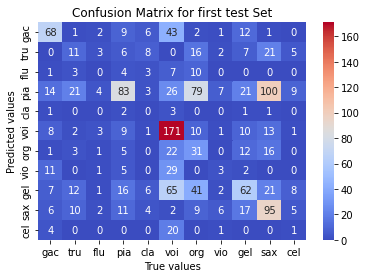

In [ ]:
CoMa_1 = plot_Confusion(CM)

[[ 41.   4.  13.  27.   0.  95.  22.  13.  14.   6.   4.]
 [  0.  10.   2.   9.   1.   9.   3.   2.   1.  11.   8.]
 [  1.   5.  12.  34.  13.   4.   6.   2.   2.   1.   7.]
 [ 34.  23.   2.  95.   8.  54.  29.  19.  29.  47.  33.]
 [  0.   3.   0.  10.   2.   2.   1.   1.   0.   0.   7.]
 [ 11.   3.  10.  17.   1. 348.  71.   5.  78.  10.   5.]
 [ 13.   2.   3.  22.   3.  56.  25.   7.  28.   5.   4.]
 [ 16.   2.   0.  18.   3.   4.   6.  19.   2.   2.   4.]
 [ 20.   8.   4.  24.   2. 170.  56.  12. 134.   9.  14.]
 [  0.   9.   0.   3.   4.  11.   8.   1.  16.  40.   2.]
 [ 10.   1.   0.  12.   0.   6.   5.   0.   5.   1.  25.]]


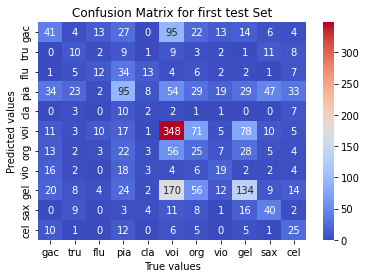

In [ ]:
CoMa_2 = plot_Confusion(CM2)

[[ 35.   3.   9.  15.   1.  29.  25.  13.   6.  10.   2.]
 [  1.   9.   0.   0.   0.   2.   6.   0.   1.  13.   0.]
 [  0.   5.  14.  11.   0.   5.   9.   1.   2.   0.   0.]
 [ 26.  14.   6.  82.   1.  27.  27.  10.   8.  49.   2.]
 [  2.   1.   4.  12.   2.   0.   0.   5.   0.   2.   0.]
 [  5.   1.   5.   4.   1. 170.  32.   1.  29.   4.   1.]
 [  0.   2.   3.   7.   0.  64.   6.   0.   9.   8.   0.]
 [  4.   3.   2.   4.   2.   5.   1.  56.   0.   1.   6.]
 [ 24.  10.   6.  19.   3.  92.  29.   8.  36.  16.   3.]
 [  7.   8.   3.   5.   0.   2.   4.   3.   3.  30.   0.]
 [  0.   0.   0.   0.   0.   4.   0.  13.   0.   0.   3.]]


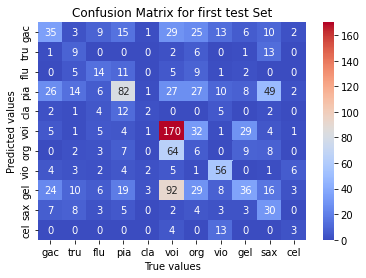

In [ ]:
CoMa_3 = plot_Confusion(CM3)

Text(33.0, 0.5, 'Predicted values')

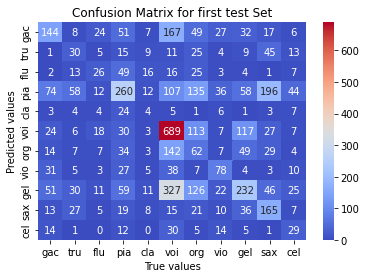

In [ ]:
  CoMa_net = CoMa_1 + CoMa_2 + CoMa_3

  g = ['gac', 'tru', 'flu', 'pia', 'cla', 'voi', 'org', 'vio', 'gel', 'sax','cel']

  sns.heatmap(CoMa_net,annot=True,cmap="coolwarm",xticklabels = g,yticklabels = g,fmt=".3g")
  plt.title("Confusion Matrix for first test Set")
  plt.xlabel("True values")
  plt.ylabel("Predicted values")

The final confusion matrix indicates that the model was able to predict 'voi' class i.e. voiced class very well . Also the piano, electric guitar classes were predicted well.

Saving the model as .h5 file

In [ ]:
model_path = r"/content/drive/Shareddrives/EE679_Project/model_NN.h5"
model.save(model_path)

In [ ]:
model_path = r"/content/drive/Shareddrives/EE679_Project/model_NN.h5"
model = keras.models.load_model(model_path)

<a name="5"></a>

# 5 Techniques learnt during the project 

- Features such as spectral centroid, spectral roll off, spectral contrast.

- K-Means clustering and Nearest neigbours rule for speech signals.

- Neural Network classifier 

- Analysis of Confusion Matrix

<a name="6"></a>
# 6 Conclusion and Future work   

- For classification of musical instruments, several temporal, spectral and coefficient space features were explored and extracted from audio file.
- After retrieving the features, these features were used to classify the instruments using template matching and statistical learning methods.
- For template matching methods, accuracy was increasing as the number of vectors in VQ Codebook was increasing but so was the computation time.
- Even for a very less set of features (mean and variance of all the features across all frames), neural network classifiers performed better than template matching techniques
- Thus, feature extraction along with modern machine learning can provide excellent results in future.




<a name="7"></a>
## References 
  1. Racharla, Karthikeya, Vineet Kumar, Chaudhari Bhushan Jayant, Ankit Khairkar, and Paturu Harish. "Predominant Musical Instrument Classification based on Spectral Features." In 2020 7th International Conference on Signal Processing and Integrated Networks (SPIN), pp. 617-622. IEEE, 2020.
  2. Bosch, Juan J., Jordi Janer, Ferdinand Fuhrmann, and Perfecto Herrera. "A Comparison of Sound Segregation Techniques for Predominant Instrument Recognition in Musical Audio Signals." In ISMIR, pp. 559-564. 2012
  3. Sharma, Anu Priya. "Implementation of ZCR and STE techniques for the detection of the voiced and unvoiced signals in Continuous Punjabi Speech." International Journal of Emerging Trends in Science and Technology 3, no. 6 (2016): 4132-4135.
  4. Molau, Sirko, Michael Pitz, Ralf Schluter, and Hermann Ney. "Computing mel-frequency cepstral coefficients on the power spectrum." In 2001 IEEE international conference on acoustics, speech, and signal processing. Proceedings (cat. No. 01CH37221), vol. 1, pp. 73-76. IEEE, 2001.
  5. Klapuri, Anssi, and Manuel Davy, eds. "Signal processing methods for music transcription." (2007).
  6. Grey, John M., and John W. Gordon. "Perceptual effects of spectral modifications on musical timbres." The Journal of the Acoustical Society of America 63, no. 5 (1978): 1493-1500.
  7. librosa: Audio and music signal analysis in python, McFee, Brian, C. Raffel, D. Liang, D. PW Ellis, M. McVicar, E. Battenberg, and O. Nieto
  8. Jiang, Dan-Ning, Lie Lu, Hong-Jiang Zhang, Jian-Hua Tao, and Lian-Hong Cai. "Music type classification by spectral contrast feature." In Proceedings. IEEE International Conference on Multimedia and Expo, vol. 1, pp. 113-116. IEEE, 2002.

